📊 Simplified Delta Analyzer Ready!

Key Functions:
- test_analyzer(): Test API connection
- analyze_symbol_delta('AAPL'): Analyze current delta patterns
- analyze_symbol_delta('AAPL', '2024-01-15'): Analyze specific date
- analyze_delta_trend('AAPL', 3): Analyze trend over 3 periods
📊 Fetching historical options data for AAPL...
✅ Retrieved 2482 options contracts
✅ Analyzer ready - found 2482 options contracts
🎯 DELTA ANALYSIS FOR AAPL
📊 Fetching historical options data for AAPL...
✅ Retrieved 2482 options contracts
🔍 Analyzing delta patterns...


/var/folders/49/6ydqkbq172ngzt6p49xfm6b00000gn/T/ipykernel_86302/3717998562.py:150: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  expiry_groups = options_df.groupby('days_to_expiry').apply(


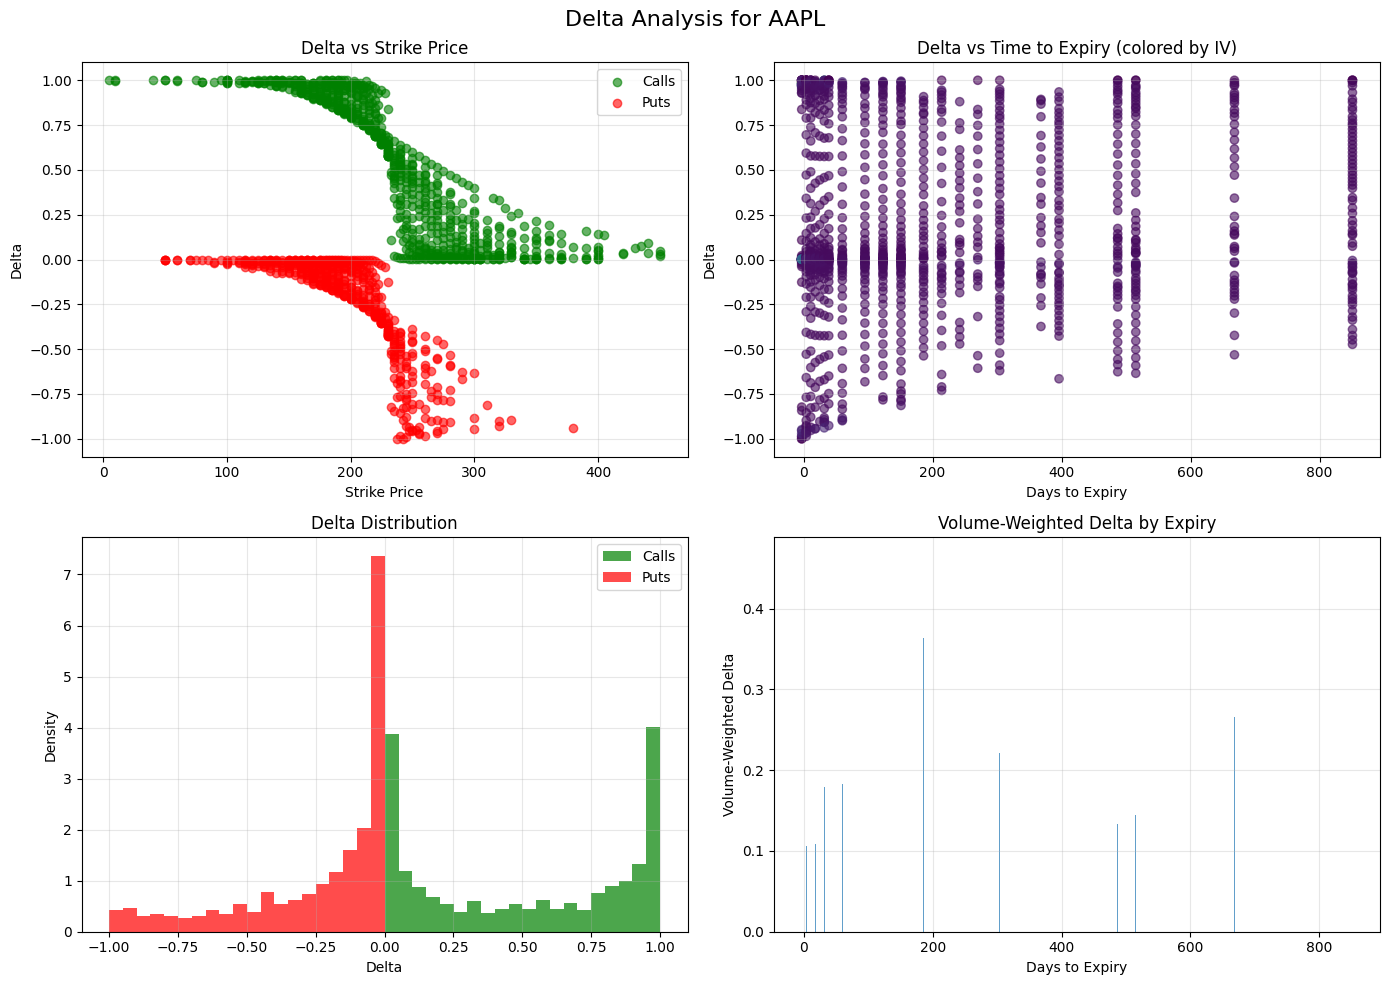


📋 DELTA ANALYSIS SUMMARY
Total Options Analyzed: 1,219
Calls: 708 | Puts: 511
Average Call Delta: 0.5174
Average Put Delta: -0.2420
Delta-IV Correlation: 0.1177
Volume-Weighted Delta: 0.1281

💡 KEY INSIGHTS
------------------------------
• Weak correlation between delta and implied volatility

🔥 MOST ACTIVE OPTIONS (by volume):
• CALL $232.5 - Delta: 0.108, Volume: 101,212
• CALL $235.0 - Delta: 0.022, Volume: 79,116
• PUT $230.0 - Delta: -0.126, Volume: 69,852
• CALL $230.0 - Delta: 0.837, Volume: 49,935
• CALL $235.0 - Delta: 0.341, Volume: 41,895


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import requests
import os
from dotenv import load_dotenv
from datetime import datetime, timedelta
import time

# Load environment variables
load_dotenv()
ALPHA_VANTAGE_API_KEY = os.getenv('ALPHA_VANTAGE_API_KEY')

class SimplifiedDeltaAnalyzer:
    """Simplified analyzer using Alpha Vantage Historical Options API for real delta data"""
    
    def __init__(self, api_key):
        self.api_key = api_key
        self.base_url = "https://www.alphavantage.co/query"
    
    def get_historical_options_data(self, symbol, date=None):
        """Get historical options data with real delta values"""
        print(f"📊 Fetching historical options data for {symbol}...")
        
        params = {
            'function': 'HISTORICAL_OPTIONS',
            'symbol': symbol,
            'apikey': self.api_key
        }
        
        if date:
            params['date'] = date
        
        try:
            response = requests.get(self.base_url, params=params)
            response.raise_for_status()
            data = response.json()
            
            if "Error Message" in data:
                print(f"❌ API Error: {data['Error Message']}")
                return None
            if "Note" in data:
                print(f"⚠️ API Note: {data['Note']}")
                return None
            
            # Parse the options data
            if 'data' not in data:
                print("❌ No options data found")
                return None
            
            options_list = []
            for option in data['data']:
                options_list.append({
                    'symbol': option.get('symbol', ''),
                    'type': option.get('type', ''),
                    'expiration': option.get('expiration', ''),
                    'strike': float(option.get('strike', 0)),
                    'last': float(option.get('last', 0)),
                    'bid': float(option.get('bid', 0)),
                    'ask': float(option.get('ask', 0)),
                    'volume': int(option.get('volume', 0)),
                    'open_interest': int(option.get('open_interest', 0)),
                    'implied_volatility': float(option.get('implied_volatility', 0)),
                    'delta': float(option.get('delta', 0)),
                    'gamma': float(option.get('gamma', 0)),
                    'theta': float(option.get('theta', 0)),
                    'vega': float(option.get('vega', 0))
                })
            
            df = pd.DataFrame(options_list)
            print(f"✅ Retrieved {len(df)} options contracts")
            return df
            
        except Exception as e:
            print(f"❌ Error fetching options data: {e}")
            return None
    
    def analyze_delta_patterns(self, options_df):
        """Analyze delta patterns from real options data"""
        if options_df is None or options_df.empty:
            return None
        
        print("🔍 Analyzing delta patterns...")
        
        # Filter for liquid options (volume > 0)
        liquid_options = options_df[options_df['volume'] > 0].copy()
        
        # Calculate days to expiration
        liquid_options['expiration_date'] = pd.to_datetime(liquid_options['expiration'])
        today = datetime.now()
        liquid_options['days_to_expiry'] = (liquid_options['expiration_date'] - today).dt.days
        
        # Calculate moneyness (assuming current stock price from ATM options)
        atm_strike = liquid_options.loc[liquid_options['delta'].abs().idxmin(), 'strike']
        liquid_options['moneyness'] = liquid_options['strike'] / atm_strike
        
        # Separate calls and puts
        calls = liquid_options[liquid_options['type'] == 'call']
        puts = liquid_options[liquid_options['type'] == 'put']
        
        analysis = {
            'total_options': len(liquid_options),
            'total_calls': len(calls),
            'total_puts': len(puts),
            'avg_call_delta': calls['delta'].mean(),
            'avg_put_delta': puts['delta'].mean(),
            'delta_volatility_corr': liquid_options['delta'].corr(liquid_options['implied_volatility']),
            'volume_weighted_delta': (liquid_options['delta'] * liquid_options['volume']).sum() / liquid_options['volume'].sum()
        }
        
        return liquid_options, analysis
    
    def plot_delta_analysis(self, options_df, symbol):
        """Create simplified delta visualizations"""
        if options_df is None or options_df.empty:
            return
        
        fig, axes = plt.subplots(2, 2, figsize=(14, 10))
        fig.suptitle(f'Delta Analysis for {symbol}', fontsize=16)
        
        # 1. Delta vs Strike Price
        calls = options_df[options_df['type'] == 'call']
        puts = options_df[options_df['type'] == 'put']
        
        axes[0, 0].scatter(calls['strike'], calls['delta'], alpha=0.6, color='green', label='Calls')
        axes[0, 0].scatter(puts['strike'], puts['delta'], alpha=0.6, color='red', label='Puts')
        axes[0, 0].set_xlabel('Strike Price')
        axes[0, 0].set_ylabel('Delta')
        axes[0, 0].set_title('Delta vs Strike Price')
        axes[0, 0].legend()
        axes[0, 0].grid(True, alpha=0.3)
        
        # 2. Delta vs Days to Expiry
        axes[0, 1].scatter(options_df['days_to_expiry'], options_df['delta'], 
                          alpha=0.6, c=options_df['implied_volatility'], cmap='viridis')
        axes[0, 1].set_xlabel('Days to Expiry')
        axes[0, 1].set_ylabel('Delta')
        axes[0, 1].set_title('Delta vs Time to Expiry (colored by IV)')
        axes[0, 1].grid(True, alpha=0.3)
        
        # 3. Delta Distribution
        axes[1, 0].hist(calls['delta'], bins=20, alpha=0.7, color='green', label='Calls', density=True)
        axes[1, 0].hist(puts['delta'], bins=20, alpha=0.7, color='red', label='Puts', density=True)
        axes[1, 0].set_xlabel('Delta')
        axes[1, 0].set_ylabel('Density')
        axes[1, 0].set_title('Delta Distribution')
        axes[1, 0].legend()
        axes[1, 0].grid(True, alpha=0.3)
        
        # 4. Volume-weighted Delta by Expiry
        expiry_groups = options_df.groupby('days_to_expiry').apply(
            lambda x: (x['delta'] * x['volume']).sum() / x['volume'].sum() if x['volume'].sum() > 0 else 0
        ).reset_index()
        expiry_groups.columns = ['days_to_expiry', 'volume_weighted_delta']
        
        axes[1, 1].bar(expiry_groups['days_to_expiry'], expiry_groups['volume_weighted_delta'], alpha=0.7)
        axes[1, 1].set_xlabel('Days to Expiry')
        axes[1, 1].set_ylabel('Volume-Weighted Delta')
        axes[1, 1].set_title('Volume-Weighted Delta by Expiry')
        axes[1, 1].grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
    
    def generate_summary_report(self, analysis, options_df):
        """Generate simplified summary report"""
        if analysis is None:
            return
        
        print(f"\n📋 DELTA ANALYSIS SUMMARY")
        print("=" * 50)
        print(f"Total Options Analyzed: {analysis['total_options']:,}")
        print(f"Calls: {analysis['total_calls']:,} | Puts: {analysis['total_puts']:,}")
        print(f"Average Call Delta: {analysis['avg_call_delta']:.4f}")
        print(f"Average Put Delta: {analysis['avg_put_delta']:.4f}")
        print(f"Delta-IV Correlation: {analysis['delta_volatility_corr']:.4f}")
        print(f"Volume-Weighted Delta: {analysis['volume_weighted_delta']:.4f}")
        
        # Key insights
        print(f"\n💡 KEY INSIGHTS")
        print("-" * 30)
        
        if analysis['delta_volatility_corr'] > 0.3:
            print("• Strong positive correlation between delta and implied volatility")
        elif analysis['delta_volatility_corr'] < -0.3:
            print("• Strong negative correlation between delta and implied volatility")
        else:
            print("• Weak correlation between delta and implied volatility")
        
        # Most active strikes
        top_volume = options_df.nlargest(5, 'volume')[['type', 'strike', 'delta', 'volume']]
        print(f"\n🔥 MOST ACTIVE OPTIONS (by volume):")
        for _, row in top_volume.iterrows():
            print(f"• {row['type'].upper()} ${row['strike']} - Delta: {row['delta']:.3f}, Volume: {row['volume']:,}")
    
    def run_analysis(self, symbol, date=None):
        """Run complete delta analysis"""
        print(f"🎯 DELTA ANALYSIS FOR {symbol}")
        print("=" * 50)
        
        # Get options data
        options_df = self.get_historical_options_data(symbol, date)
        if options_df is None:
            return None
        
        # Analyze patterns
        filtered_df, analysis = self.analyze_delta_patterns(options_df)
        if analysis is None:
            return None
        
        # Create visualizations
        self.plot_delta_analysis(filtered_df, symbol)
        
        # Generate report
        self.generate_summary_report(analysis, filtered_df)
        
        return filtered_df, analysis

# Simplified test and usage functions
def test_analyzer():
    """Test the analyzer connection"""
    if not ALPHA_VANTAGE_API_KEY:
        print("❌ No API key found. Please set ALPHA_VANTAGE_API_KEY in your .env file")
        return False
    
    analyzer = SimplifiedDeltaAnalyzer(ALPHA_VANTAGE_API_KEY)
    
    # Test with a simple API call
    try:
        test_data = analyzer.get_historical_options_data('AAPL')
        if test_data is not None:
            print(f"✅ Analyzer ready - found {len(test_data)} options contracts")
            return True
        else:
            print("❌ No data returned from API")
            return False
    except Exception as e:
        print(f"❌ Test failed: {e}")
        return False

def analyze_symbol_delta(symbol='AAPL', date=None):
    """Analyze delta patterns for a symbol"""
    if not test_analyzer():
        return None
    
    analyzer = SimplifiedDeltaAnalyzer(ALPHA_VANTAGE_API_KEY)
    return analyzer.run_analysis(symbol, date)

# Multiple date analysis
def analyze_delta_trend(symbol='AAPL', days_back=5):
    """Analyze delta trends over multiple days"""
    if not test_analyzer():
        return None
    
    analyzer = SimplifiedDeltaAnalyzer(ALPHA_VANTAGE_API_KEY)
    all_data = []
    
    for i in range(days_back):
        date = (datetime.now() - timedelta(days=i*2)).strftime('%Y-%m-%d')  # Every 2 days
        print(f"\nAnalyzing {symbol} for {date}...")
        
        options_df = analyzer.get_historical_options_data(symbol, date)
        if options_df is not None and not options_df.empty:
            options_df['analysis_date'] = date
            all_data.append(options_df)
        
        time.sleep(12)  # Rate limiting
    
    if all_data:
        combined_df = pd.concat(all_data, ignore_index=True)
        print(f"\n📊 Combined analysis of {len(combined_df)} options across {days_back} periods")
        
        # Simple trend analysis
        trend_analysis = combined_df.groupby('analysis_date').agg({
            'delta': ['mean', 'std'],
            'implied_volatility': 'mean',
            'volume': 'sum'
        }).round(4)
        
        print("\nDelta trends over time:")
        print(trend_analysis)
        
        return combined_df
    
    return None

# Ready to use!
print("📊 Simplified Delta Analyzer Ready!")
print("\nKey Functions:")
print("- test_analyzer(): Test API connection")
print("- analyze_symbol_delta('AAPL'): Analyze current delta patterns")
print("- analyze_symbol_delta('AAPL', '2024-01-15'): Analyze specific date")
print("- analyze_delta_trend('AAPL', 3): Analyze trend over 3 periods")

if __name__ == "__main__":
    # Run demo
    analyze_symbol_delta('AAPL')

📊 Enhanced Delta Analyzer with Put/Call Tables Ready!

Key Functions:
- test_analyzer(): Test API connection
- analyze_symbol_delta('AAPL'): Full analysis with tables
- analyze_symbol_delta('AAPL', export_csv=True): Export tables to CSV
- analyze_symbol_delta('AAPL', '2024-01-15'): Analyze specific date
- analyze_delta_trend('AAPL', 3): Multi-day trend analysis
- compare_symbols_delta('AAPL', 'MSFT', 'GOOGL'): Compare multiple symbols
📊 Fetching historical options data for AAPL...
✅ Retrieved 2378 options contracts
✅ Analyzer ready - found 2378 options contracts
🎯 DELTA ANALYSIS FOR AAPL
📊 Fetching historical options data for AAPL...
✅ Retrieved 2378 options contracts
🔍 Analyzing delta patterns...
📋 Creating detailed puts and calls tables...
📊 Creating delta summary tables...

📈 CALLS TABLE (Top 15 by Delta)
 strike expiration  days_to_expiry   last  delta  volume  open_interest  implied_volatility  spread_pct
  100.0 2026-06-18             303 134.50    1.0       1           2307     

/var/folders/49/6ydqkbq172ngzt6p49xfm6b00000gn/T/ipykernel_22320/3412102698.py:158: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  moneyness_summary = liquid_options.groupby(['type', 'moneyness_category']).agg({
/var/folders/49/6ydqkbq172ngzt6p49xfm6b00000gn/T/ipykernel_22320/3412102698.py:166: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  dte_summary = liquid_options.groupby(['type', 'dte_category']).agg({
/var/folders/49/6ydqkbq172ngzt6p49xfm6b00000gn/T/ipykernel_22320/3412102698.py:311: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future 

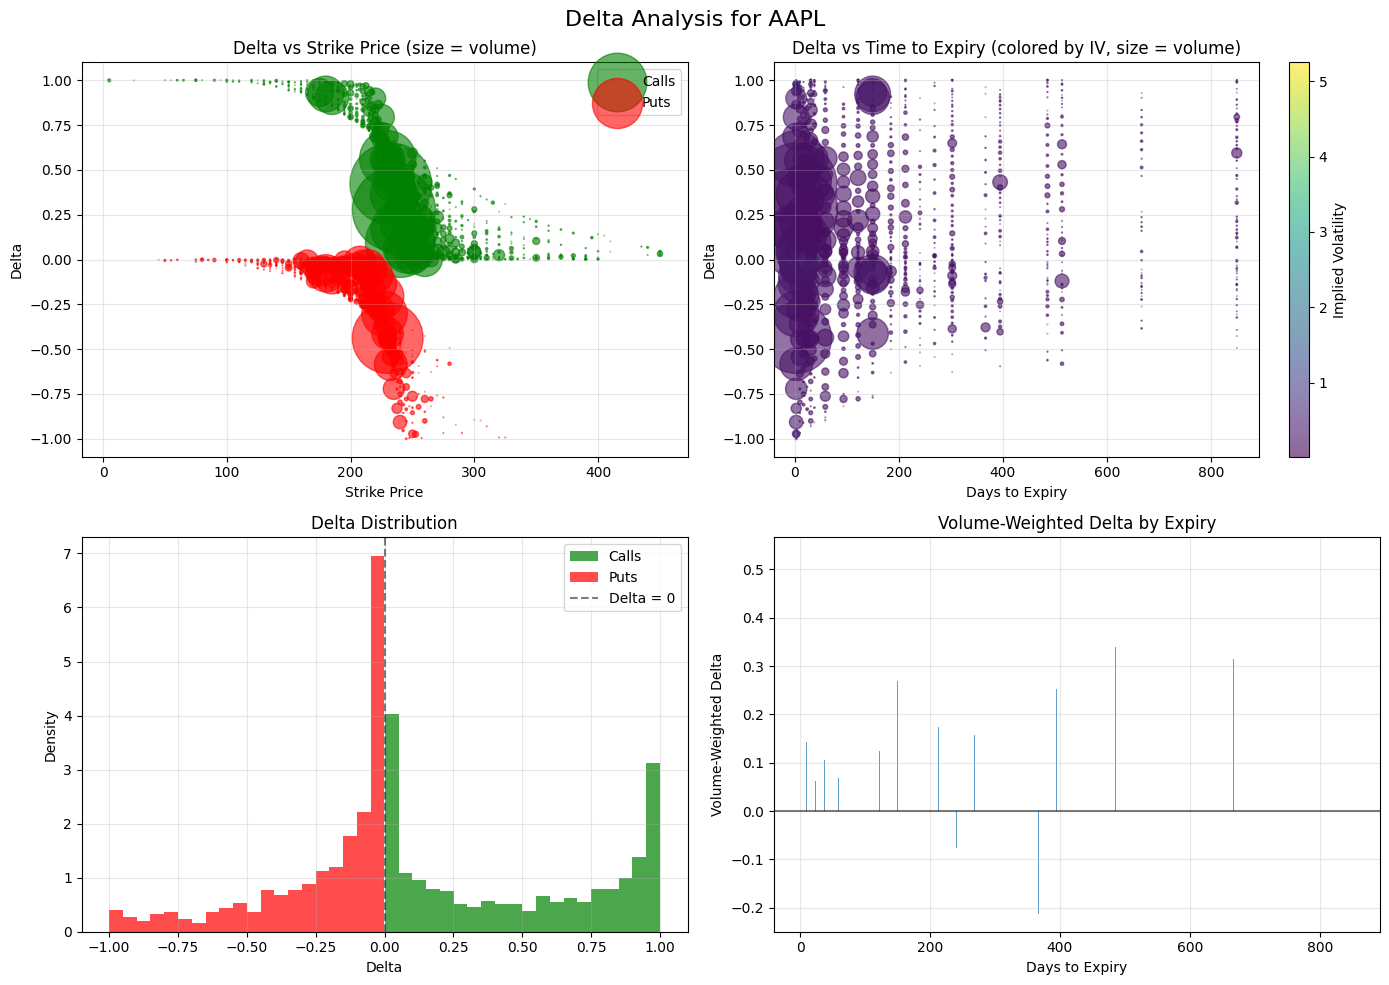


📋 DELTA ANALYSIS SUMMARY
Total Options Analyzed: 1,163
Calls: 665 | Puts: 498
Average Call Delta: 0.4886
Average Put Delta: -0.2296
Delta-IV Correlation: 0.1065
Volume-Weighted Delta: 0.1210
ATM Strike Estimate: $80.00

💡 KEY INSIGHTS
------------------------------
• Weak correlation between delta and implied volatility
• Market shows bullish delta skew (VW Delta: 0.121)
📁 Calls table exported to: AAPL_calls_delta_analysis_current_20250818_215821.csv
📁 Puts table exported to: AAPL_puts_delta_analysis_current_20250818_215821.csv


In [1]:
# table
import pandas as pd
import matplotlib.pyplot as plt
import requests
import os
from dotenv import load_dotenv
from datetime import datetime, timedelta
import time

# Load environment variables
load_dotenv()
ALPHA_VANTAGE_API_KEY = os.getenv('ALPHA_VANTAGE_API_KEY')

class SimplifiedDeltaAnalyzer:
    """Simplified analyzer using Alpha Vantage Historical Options API for real delta data"""
    
    def __init__(self, api_key):
        self.api_key = api_key
        self.base_url = "https://www.alphavantage.co/query"
    
    def get_historical_options_data(self, symbol, date=None):
        """Get historical options data with real delta values"""
        print(f"📊 Fetching historical options data for {symbol}...")
        
        params = {
            'function': 'HISTORICAL_OPTIONS',
            'symbol': symbol,
            'apikey': self.api_key
        }
        
        if date:
            params['date'] = date
        
        try:
            response = requests.get(self.base_url, params=params)
            response.raise_for_status()
            data = response.json()
            
            if "Error Message" in data:
                print(f"❌ API Error: {data['Error Message']}")
                return None
            if "Note" in data:
                print(f"⚠️ API Note: {data['Note']}")
                return None
            
            # Parse the options data
            if 'data' not in data:
                print("❌ No options data found")
                return None
            
            options_list = []
            for option in data['data']:
                options_list.append({
                    'symbol': option.get('symbol', ''),
                    'type': option.get('type', ''),
                    'expiration': option.get('expiration', ''),
                    'strike': float(option.get('strike', 0)),
                    'last': float(option.get('last', 0)),
                    'bid': float(option.get('bid', 0)),
                    'ask': float(option.get('ask', 0)),
                    'volume': int(option.get('volume', 0)),
                    'open_interest': int(option.get('open_interest', 0)),
                    'implied_volatility': float(option.get('implied_volatility', 0)),
                    'delta': float(option.get('delta', 0)),
                    'gamma': float(option.get('gamma', 0)),
                    'theta': float(option.get('theta', 0)),
                    'vega': float(option.get('vega', 0))
                })
            
            df = pd.DataFrame(options_list)
            print(f"✅ Retrieved {len(df)} options contracts")
            return df
            
        except Exception as e:
            print(f"❌ Error fetching options data: {e}")
            return None
    
    def create_puts_calls_tables(self, options_df):
        """Create comprehensive tables for puts and calls analysis"""
        if options_df is None or options_df.empty:
            return None, None
        
        print("📋 Creating detailed puts and calls tables...")
        
        # Filter for liquid options (volume > 0)
        liquid_options = options_df[options_df['volume'] > 0].copy()
        
        # Calculate additional metrics
        liquid_options['expiration_date'] = pd.to_datetime(liquid_options['expiration'])
        today = datetime.now()
        liquid_options['days_to_expiry'] = (liquid_options['expiration_date'] - today).dt.days
        
        # Calculate moneyness
        atm_strike = liquid_options.loc[liquid_options['delta'].abs().idxmin(), 'strike']
        liquid_options['moneyness'] = liquid_options['strike'] / atm_strike
        liquid_options['mid_price'] = (liquid_options['bid'] + liquid_options['ask']) / 2
        liquid_options['spread'] = liquid_options['ask'] - liquid_options['bid']
        liquid_options['spread_pct'] = (liquid_options['spread'] / liquid_options['mid_price']) * 100
        
        # Create calls table
        calls = liquid_options[liquid_options['type'] == 'call'].copy()
        calls_table = calls[['strike', 'expiration', 'days_to_expiry', 'last', 'bid', 'ask', 
                           'mid_price', 'volume', 'open_interest', 'delta', 'gamma', 
                           'theta', 'vega', 'implied_volatility', 'moneyness', 'spread_pct']].copy()
        
        # Sort calls by delta (descending)
        calls_table = calls_table.sort_values('delta', ascending=False)
        
        # Create puts table
        puts = liquid_options[liquid_options['type'] == 'put'].copy()
        puts_table = puts[['strike', 'expiration', 'days_to_expiry', 'last', 'bid', 'ask', 
                          'mid_price', 'volume', 'open_interest', 'delta', 'gamma', 
                          'theta', 'vega', 'implied_volatility', 'moneyness', 'spread_pct']].copy()
        
        # Sort puts by delta (ascending, since puts have negative delta)
        puts_table = puts_table.sort_values('delta', ascending=True)
        
        # Round numeric columns for better display
        numeric_cols = ['last', 'bid', 'ask', 'mid_price', 'delta', 'gamma', 'theta', 
                       'vega', 'implied_volatility', 'moneyness', 'spread_pct']
        calls_table[numeric_cols] = calls_table[numeric_cols].round(4)
        puts_table[numeric_cols] = puts_table[numeric_cols].round(4)
        
        return calls_table, puts_table
    
    def create_delta_summary_tables(self, options_df):
        """Create summary tables grouped by key characteristics"""
        if options_df is None or options_df.empty:
            return None
        
        print("📊 Creating delta summary tables...")
        
        # Filter for liquid options
        liquid_options = options_df[options_df['volume'] > 0].copy()
        liquid_options['expiration_date'] = pd.to_datetime(liquid_options['expiration'])
        today = datetime.now()
        liquid_options['days_to_expiry'] = (liquid_options['expiration_date'] - today).dt.days
        
        # Calculate moneyness
        atm_strike = liquid_options.loc[liquid_options['delta'].abs().idxmin(), 'strike']
        liquid_options['moneyness'] = liquid_options['strike'] / atm_strike
        
        # Create moneyness categories
        liquid_options['moneyness_category'] = pd.cut(
            liquid_options['moneyness'], 
            bins=[0, 0.95, 1.05, float('inf')], 
            labels=['OTM', 'ATM', 'ITM']
        )
        
        # Create time to expiry categories
        liquid_options['dte_category'] = pd.cut(
            liquid_options['days_to_expiry'], 
            bins=[0, 7, 30, 90, float('inf')], 
            labels=['<7d', '7-30d', '30-90d', '>90d']
        )
        
        # Summary by moneyness and type
        moneyness_summary = liquid_options.groupby(['type', 'moneyness_category']).agg({
            'delta': ['mean', 'std', 'count'],
            'volume': ['sum', 'mean'],
            'open_interest': 'sum',
            'implied_volatility': 'mean'
        }).round(4)
        
        # Summary by time to expiry and type
        dte_summary = liquid_options.groupby(['type', 'dte_category']).agg({
            'delta': ['mean', 'std', 'count'],
            'volume': ['sum', 'mean'],
            'open_interest': 'sum',
            'implied_volatility': 'mean'
        }).round(4)
        
        # Top options by volume for each type
        top_calls = liquid_options[liquid_options['type'] == 'call'].nlargest(10, 'volume')[
            ['strike', 'expiration', 'delta', 'volume', 'open_interest', 'implied_volatility']
        ].round(4)
        
        top_puts = liquid_options[liquid_options['type'] == 'put'].nlargest(10, 'volume')[
            ['strike', 'expiration', 'delta', 'volume', 'open_interest', 'implied_volatility']
        ].round(4)
        
        return {
            'moneyness_summary': moneyness_summary,
            'dte_summary': dte_summary,
            'top_calls': top_calls,
            'top_puts': top_puts
        }
    
    def display_tables(self, calls_table, puts_table, summary_tables):
        """Display all tables in a formatted way"""
        print("\n" + "="*80)
        print("📈 CALLS TABLE (Top 15 by Delta)")
        print("="*80)
        if calls_table is not None and not calls_table.empty:
            display_calls = calls_table.head(15)[['strike', 'expiration', 'days_to_expiry', 
                                                'last', 'delta', 'volume', 'open_interest', 
                                                'implied_volatility', 'spread_pct']]
            print(display_calls.to_string(index=False))
        else:
            print("No calls data available")
        
        print("\n" + "="*80)
        print("📉 PUTS TABLE (Top 15 by |Delta|)")
        print("="*80)
        if puts_table is not None and not puts_table.empty:
            display_puts = puts_table.head(15)[['strike', 'expiration', 'days_to_expiry', 
                                              'last', 'delta', 'volume', 'open_interest', 
                                              'implied_volatility', 'spread_pct']]
            print(display_puts.to_string(index=False))
        else:
            print("No puts data available")
        
        if summary_tables:
            print("\n" + "="*80)
            print("📊 DELTA SUMMARY BY MONEYNESS")
            print("="*80)
            print(summary_tables['moneyness_summary'])
            
            print("\n" + "="*80)
            print("📊 DELTA SUMMARY BY TIME TO EXPIRY")
            print("="*80)
            print(summary_tables['dte_summary'])
            
            print("\n" + "="*60)
            print("🔥 TOP 10 CALLS BY VOLUME")
            print("="*60)
            print(summary_tables['top_calls'].to_string(index=False))
            
            print("\n" + "="*60)
            print("🔥 TOP 10 PUTS BY VOLUME")
            print("="*60)
            print(summary_tables['top_puts'].to_string(index=False))
    
    def analyze_delta_patterns(self, options_df):
        """Analyze delta patterns from real options data"""
        if options_df is None or options_df.empty:
            return None
        
        print("🔍 Analyzing delta patterns...")
        
        # Filter for liquid options (volume > 0)
        liquid_options = options_df[options_df['volume'] > 0].copy()
        
        # Calculate days to expiration
        liquid_options['expiration_date'] = pd.to_datetime(liquid_options['expiration'])
        today = datetime.now()
        liquid_options['days_to_expiry'] = (liquid_options['expiration_date'] - today).dt.days
        
        # Calculate moneyness (assuming current stock price from ATM options)
        atm_strike = liquid_options.loc[liquid_options['delta'].abs().idxmin(), 'strike']
        liquid_options['moneyness'] = liquid_options['strike'] / atm_strike
        
        # Separate calls and puts
        calls = liquid_options[liquid_options['type'] == 'call']
        puts = liquid_options[liquid_options['type'] == 'put']
        
        analysis = {
            'total_options': len(liquid_options),
            'total_calls': len(calls),
            'total_puts': len(puts),
            'avg_call_delta': calls['delta'].mean(),
            'avg_put_delta': puts['delta'].mean(),
            'delta_volatility_corr': liquid_options['delta'].corr(liquid_options['implied_volatility']),
            'volume_weighted_delta': (liquid_options['delta'] * liquid_options['volume']).sum() / liquid_options['volume'].sum(),
            'atm_strike': atm_strike
        }
        
        return liquid_options, analysis
    
    def plot_delta_analysis(self, options_df, symbol):
        """Create simplified delta visualizations"""
        if options_df is None or options_df.empty:
            return
        
        fig, axes = plt.subplots(2, 2, figsize=(14, 10))
        fig.suptitle(f'Delta Analysis for {symbol}', fontsize=16)
        
        # 1. Delta vs Strike Price
        calls = options_df[options_df['type'] == 'call']
        puts = options_df[options_df['type'] == 'put']
        
        axes[0, 0].scatter(calls['strike'], calls['delta'], alpha=0.6, color='green', label='Calls', s=calls['volume']/10)
        axes[0, 0].scatter(puts['strike'], puts['delta'], alpha=0.6, color='red', label='Puts', s=puts['volume']/10)
        axes[0, 0].set_xlabel('Strike Price')
        axes[0, 0].set_ylabel('Delta')
        axes[0, 0].set_title('Delta vs Strike Price (size = volume)')
        axes[0, 0].legend()
        axes[0, 0].grid(True, alpha=0.3)
        
        # 2. Delta vs Days to Expiry
        scatter = axes[0, 1].scatter(options_df['days_to_expiry'], options_df['delta'], 
                                   alpha=0.6, c=options_df['implied_volatility'], cmap='viridis',
                                   s=options_df['volume']/10)
        axes[0, 1].set_xlabel('Days to Expiry')
        axes[0, 1].set_ylabel('Delta')
        axes[0, 1].set_title('Delta vs Time to Expiry (colored by IV, size = volume)')
        axes[0, 1].grid(True, alpha=0.3)
        plt.colorbar(scatter, ax=axes[0, 1], label='Implied Volatility')
        
        # 3. Delta Distribution
        axes[1, 0].hist(calls['delta'], bins=20, alpha=0.7, color='green', label='Calls', density=True)
        axes[1, 0].hist(puts['delta'], bins=20, alpha=0.7, color='red', label='Puts', density=True)
        axes[1, 0].axvline(0, color='black', linestyle='--', alpha=0.5, label='Delta = 0')
        axes[1, 0].set_xlabel('Delta')
        axes[1, 0].set_ylabel('Density')
        axes[1, 0].set_title('Delta Distribution')
        axes[1, 0].legend()
        axes[1, 0].grid(True, alpha=0.3)
        
        # 4. Volume-weighted Delta by Expiry
        expiry_groups = options_df.groupby('days_to_expiry').apply(
            lambda x: (x['delta'] * x['volume']).sum() / x['volume'].sum() if x['volume'].sum() > 0 else 0
        ).reset_index()
        expiry_groups.columns = ['days_to_expiry', 'volume_weighted_delta']
        
        axes[1, 1].bar(expiry_groups['days_to_expiry'], expiry_groups['volume_weighted_delta'], alpha=0.7)
        axes[1, 1].axhline(0, color='black', linestyle='-', alpha=0.5)
        axes[1, 1].set_xlabel('Days to Expiry')
        axes[1, 1].set_ylabel('Volume-Weighted Delta')
        axes[1, 1].set_title('Volume-Weighted Delta by Expiry')
        axes[1, 1].grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
    
    def generate_summary_report(self, analysis, options_df):
        """Generate simplified summary report"""
        if analysis is None:
            return
        
        print(f"\n📋 DELTA ANALYSIS SUMMARY")
        print("=" * 50)
        print(f"Total Options Analyzed: {analysis['total_options']:,}")
        print(f"Calls: {analysis['total_calls']:,} | Puts: {analysis['total_puts']:,}")
        print(f"Average Call Delta: {analysis['avg_call_delta']:.4f}")
        print(f"Average Put Delta: {analysis['avg_put_delta']:.4f}")
        print(f"Delta-IV Correlation: {analysis['delta_volatility_corr']:.4f}")
        print(f"Volume-Weighted Delta: {analysis['volume_weighted_delta']:.4f}")
        print(f"ATM Strike Estimate: ${analysis['atm_strike']:.2f}")
        
        # Key insights
        print(f"\n💡 KEY INSIGHTS")
        print("-" * 30)
        
        if analysis['delta_volatility_corr'] > 0.3:
            print("• Strong positive correlation between delta and implied volatility")
        elif analysis['delta_volatility_corr'] < -0.3:
            print("• Strong negative correlation between delta and implied volatility")
        else:
            print("• Weak correlation between delta and implied volatility")
        
        # Delta skew analysis
        if abs(analysis['volume_weighted_delta']) > 0.1:
            direction = "bullish" if analysis['volume_weighted_delta'] > 0 else "bearish"
            print(f"• Market shows {direction} delta skew (VW Delta: {analysis['volume_weighted_delta']:.3f})")
        else:
            print("• Relatively balanced delta exposure across options")
    
    def export_tables_to_csv(self, calls_table, puts_table, symbol, date_str=""):
        """Export tables to CSV files"""
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        
        if calls_table is not None and not calls_table.empty:
            calls_filename = f"{symbol}_calls_delta_analysis_{date_str}_{timestamp}.csv"
            calls_table.to_csv(calls_filename, index=False)
            print(f"📁 Calls table exported to: {calls_filename}")
        
        if puts_table is not None and not puts_table.empty:
            puts_filename = f"{symbol}_puts_delta_analysis_{date_str}_{timestamp}.csv"
            puts_table.to_csv(puts_filename, index=False)
            print(f"📁 Puts table exported to: {puts_filename}")
    
    def run_analysis(self, symbol, date=None, export_csv=False):
        """Run complete delta analysis with tables"""
        print(f"🎯 DELTA ANALYSIS FOR {symbol}")
        print("=" * 50)
        
        # Get options data
        options_df = self.get_historical_options_data(symbol, date)
        if options_df is None:
            return None
        
        # Analyze patterns
        filtered_df, analysis = self.analyze_delta_patterns(options_df)
        if analysis is None:
            return None
        
        # Create puts and calls tables
        calls_table, puts_table = self.create_puts_calls_tables(filtered_df)
        
        # Create summary tables
        summary_tables = self.create_delta_summary_tables(filtered_df)
        
        # Display all tables
        self.display_tables(calls_table, puts_table, summary_tables)
        
        # Create visualizations
        self.plot_delta_analysis(filtered_df, symbol)
        
        # Generate report
        self.generate_summary_report(analysis, filtered_df)
        
        # Export to CSV if requested
        if export_csv:
            date_str = date if date else "current"
            self.export_tables_to_csv(calls_table, puts_table, symbol, date_str)
        
        return {
            'raw_data': filtered_df,
            'analysis': analysis,
            'calls_table': calls_table,
            'puts_table': puts_table,
            'summary_tables': summary_tables
        }

# Enhanced convenience functions
def test_analyzer():
    """Test the analyzer connection"""
    if not ALPHA_VANTAGE_API_KEY:
        print("❌ No API key found. Please set ALPHA_VANTAGE_API_KEY in your .env file")
        return False
    
    analyzer = SimplifiedDeltaAnalyzer(ALPHA_VANTAGE_API_KEY)
    
    # Test with a simple API call
    try:
        test_data = analyzer.get_historical_options_data('AAPL')
        if test_data is not None:
            print(f"✅ Analyzer ready - found {len(test_data)} options contracts")
            return True
        else:
            print("❌ No data returned from API")
            return False
    except Exception as e:
        print(f"❌ Test failed: {e}")
        return False

def analyze_symbol_delta(symbol='AAPL', date=None, export_csv=False):
    """Analyze delta patterns for a symbol with comprehensive tables"""
    if not test_analyzer():
        return None
    
    analyzer = SimplifiedDeltaAnalyzer(ALPHA_VANTAGE_API_KEY)
    return analyzer.run_analysis(symbol, date, export_csv)

def analyze_delta_trend(symbol='AAPL', days_back=5):
    """Analyze delta trends over multiple days"""
    if not test_analyzer():
        return None
    
    analyzer = SimplifiedDeltaAnalyzer(ALPHA_VANTAGE_API_KEY)
    all_data = []
    
    for i in range(days_back):
        date = (datetime.now() - timedelta(days=i*2)).strftime('%Y-%m-%d')  # Every 2 days
        print(f"\nAnalyzing {symbol} for {date}...")
        
        options_df = analyzer.get_historical_options_data(symbol, date)
        if options_df is not None and not options_df.empty:
            options_df['analysis_date'] = date
            all_data.append(options_df)
        
        time.sleep(12)  # Rate limiting
    
    if all_data:
        combined_df = pd.concat(all_data, ignore_index=True)
        print(f"\n📊 Combined analysis of {len(combined_df)} options across {days_back} periods")
        
        # Enhanced trend analysis with tables
        trend_analysis = combined_df.groupby(['analysis_date', 'type']).agg({
            'delta': ['mean', 'std'],
            'implied_volatility': 'mean',
            'volume': 'sum',
            'open_interest': 'sum'
        }).round(4)
        
        print("\n" + "="*80)
        print("📈 DELTA TRENDS OVER TIME")
        print("="*80)
        print(trend_analysis)
        
        # Daily volume-weighted delta
        daily_vw_delta = combined_df.groupby('analysis_date').apply(
            lambda x: (x['delta'] * x['volume']).sum() / x['volume'].sum() if x['volume'].sum() > 0 else 0
        ).round(4)
        
        print("\n" + "="*50)
        print("📊 DAILY VOLUME-WEIGHTED DELTA")
        print("="*50)
        for date, vw_delta in daily_vw_delta.items():
            print(f"{date}: {vw_delta:+.4f}")
        
        return combined_df
    
    return None

def compare_symbols_delta(*symbols):
    """Compare delta patterns across multiple symbols"""
    if not test_analyzer():
        return None
    
    analyzer = SimplifiedDeltaAnalyzer(ALPHA_VANTAGE_API_KEY)
    comparison_data = {}
    
    for symbol in symbols:
        print(f"\n🎯 Analyzing {symbol}...")
        result = analyzer.run_analysis(symbol)
        if result:
            comparison_data[symbol] = result
        time.sleep(12)  # Rate limiting
    
    # Create comparison table
    if comparison_data:
        comparison_summary = []
        for symbol, data in comparison_data.items():
            analysis = data['analysis']
            comparison_summary.append({
                'Symbol': symbol,
                'Total_Options': analysis['total_options'],
                'Calls': analysis['total_calls'],
                'Puts': analysis['total_puts'],
                'Avg_Call_Delta': round(analysis['avg_call_delta'], 4),
                'Avg_Put_Delta': round(analysis['avg_put_delta'], 4),
                'VW_Delta': round(analysis['volume_weighted_delta'], 4),
                'Delta_IV_Corr': round(analysis['delta_volatility_corr'], 4),
                'ATM_Strike': round(analysis['atm_strike'], 2)
            })
        
        comparison_df = pd.DataFrame(comparison_summary)
        
        print("\n" + "="*100)
        print("📊 MULTI-SYMBOL DELTA COMPARISON")
        print("="*100)
        print(comparison_df.to_string(index=False))
        
        return comparison_data, comparison_df
    
    return None

# Ready to use!
print("📊 Enhanced Delta Analyzer with Put/Call Tables Ready!")
print("\nKey Functions:")
print("- test_analyzer(): Test API connection")
print("- analyze_symbol_delta('AAPL'): Full analysis with tables")
print("- analyze_symbol_delta('AAPL', export_csv=True): Export tables to CSV")
print("- analyze_symbol_delta('AAPL', '2024-01-15'): Analyze specific date")
print("- analyze_delta_trend('AAPL', 3): Multi-day trend analysis")
print("- compare_symbols_delta('AAPL', 'MSFT', 'GOOGL'): Compare multiple symbols")

if __name__ == "__main__":
    # Run demo with tables
    result = analyze_symbol_delta('AAPL', export_csv=True)

🚀 Delta Change Analyzer Ready!

Usage:
result = analyze_delta_changes_from_csv('AAPL_puts_delta_analysis_current_20250818_215821.csv')

This will:
• Load your historical puts data from CSV
• Fetch current options data from Alpha Vantage
• Calculate delta changes for matching strikes
• Display comprehensive analysis tables
• Create visualizations
• Export results to new CSV file
🎯 DELTA CHANGE ANALYSIS FOR AAPL
✅ Loaded 498 puts contracts from AAPL_puts_delta_analysis_current_20250818_215821.csv
📊 Columns: ['strike', 'expiration', 'days_to_expiry', 'last', 'bid', 'ask', 'mid_price', 'volume', 'open_interest', 'delta', 'gamma', 'theta', 'vega', 'implied_volatility', 'moneyness', 'spread_pct']
📈 Strike range: $45.00 - $325.00
🔄 Fetching current options data for AAPL...
✅ Retrieved 1189 current puts contracts
🧮 Calculating delta changes...
✅ Calculated delta changes for 498 matching strikes

📊 DELTA CHANGE ANALYSIS SUMMARY
Total Options Analyzed: 498
Average Delta Change: -0.000002
Median 

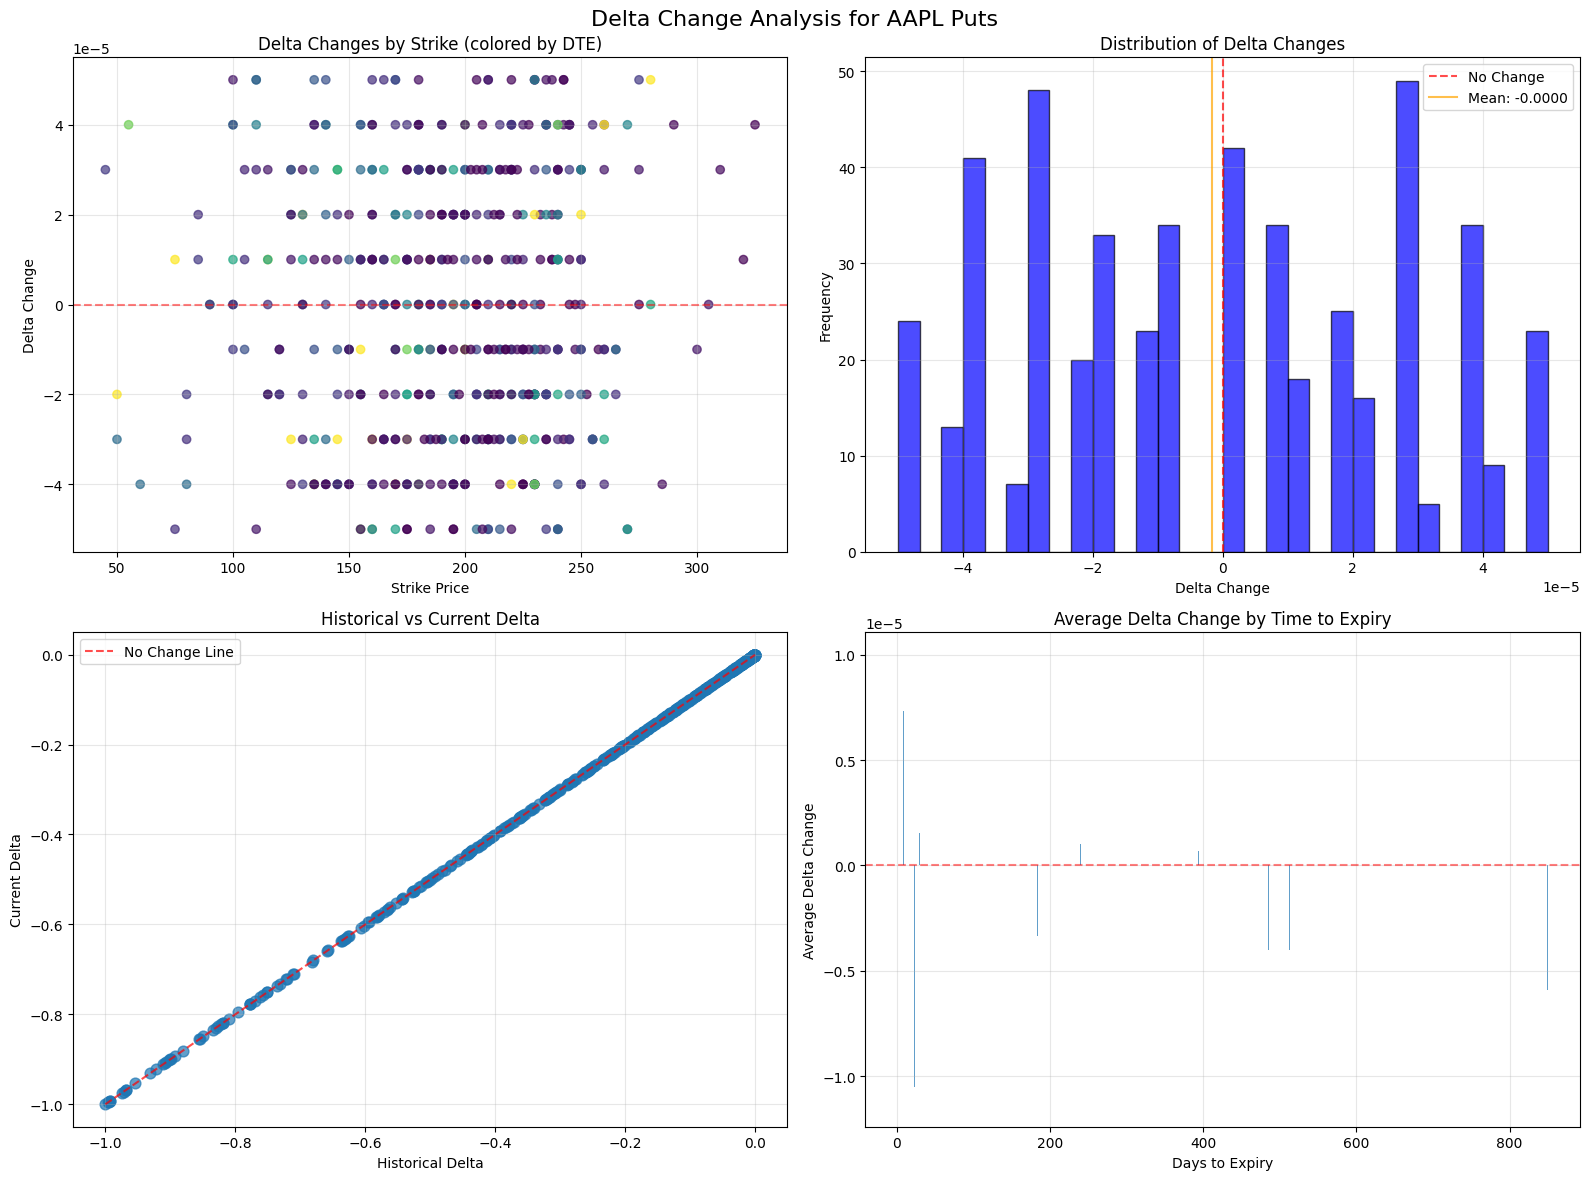

📁 Delta changes exported to: AAPL_delta_changes_20250819_180031.csv


In [3]:
# Self-contained Delta Change Analyzer for AAPL Puts
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import requests
import os
from dotenv import load_dotenv

# Load environment variables
load_dotenv()
ALPHA_VANTAGE_API_KEY = os.getenv('ALPHA_VANTAGE_API_KEY')

class DeltaChangeAnalyzer:
    """Analyze delta changes for specific strikes from historical CSV data"""
    
    def __init__(self, api_key):
        self.api_key = api_key
        self.base_url = "https://www.alphavantage.co/query"
    
    def load_historical_csv(self, csv_path):
        """Load the historical puts data from CSV"""
        try:
            df = pd.read_csv(csv_path)
            print(f"✅ Loaded {len(df)} puts contracts from {csv_path}")
            print(f"📊 Columns: {list(df.columns)}")
            print(f"📈 Strike range: ${df['strike'].min():.2f} - ${df['strike'].max():.2f}")
            return df
        except Exception as e:
            print(f"❌ Error loading CSV: {e}")
            return None
    
    def get_current_options_data(self, symbol='AAPL'):
        """Get current options data from Alpha Vantage"""
        print(f"🔄 Fetching current options data for {symbol}...")
        
        params = {
            'function': 'HISTORICAL_OPTIONS',
            'symbol': symbol,
            'apikey': self.api_key
        }
        
        try:
            response = requests.get(self.base_url, params=params)
            response.raise_for_status()
            data = response.json()
            
            if "Error Message" in data:
                print(f"❌ API Error: {data['Error Message']}")
                return None
            if "Note" in data:
                print(f"⚠️ API Note: {data['Note']}")
                return None
            
            if 'data' not in data:
                print("❌ No options data found")
                return None
            
            options_list = []
            for option in data['data']:
                options_list.append({
                    'symbol': option.get('symbol', ''),
                    'type': option.get('type', ''),
                    'expiration': option.get('expiration', ''),
                    'strike': float(option.get('strike', 0)),
                    'last': float(option.get('last', 0)),
                    'bid': float(option.get('bid', 0)),
                    'ask': float(option.get('ask', 0)),
                    'volume': int(option.get('volume', 0)),
                    'open_interest': int(option.get('open_interest', 0)),
                    'implied_volatility': float(option.get('implied_volatility', 0)),
                    'delta': float(option.get('delta', 0)),
                    'gamma': float(option.get('gamma', 0)),
                    'theta': float(option.get('theta', 0)),
                    'vega': float(option.get('vega', 0))
                })
            
            df = pd.DataFrame(options_list)
            # Filter for puts only
            puts_df = df[df['type'] == 'put'].copy()
            print(f"✅ Retrieved {len(puts_df)} current puts contracts")
            return puts_df
            
        except Exception as e:
            print(f"❌ Error fetching current data: {e}")
            return None
    
    def calculate_delta_changes(self, historical_df, current_df, strike_tolerance=0.01):
        """Calculate delta changes for matching strikes"""
        print("🧮 Calculating delta changes...")
        
        # Ensure both dataframes have the required columns
        required_cols = ['strike', 'delta', 'expiration']
        for col in required_cols:
            if col not in historical_df.columns:
                print(f"❌ Missing column '{col}' in historical data")
                return None
            if col not in current_df.columns:
                print(f"❌ Missing column '{col}' in current data")
                return None
        
        delta_changes = []
        
        for _, hist_row in historical_df.iterrows():
            hist_strike = hist_row['strike']
            hist_expiration = hist_row['expiration']
            hist_delta = hist_row['delta']
            
            # Find matching current option (same strike and expiration)
            matching_current = current_df[
                (abs(current_df['strike'] - hist_strike) <= strike_tolerance) &
                (current_df['expiration'] == hist_expiration)
            ]
            
            if not matching_current.empty:
                current_delta = matching_current.iloc[0]['delta']
                delta_change = current_delta - hist_delta
                
                change_data = {
                    'strike': hist_strike,
                    'expiration': hist_expiration,
                    'historical_delta': hist_delta,
                    'current_delta': current_delta,
                    'delta_change': delta_change,
                    'delta_change_pct': (delta_change / abs(hist_delta)) * 100 if hist_delta != 0 else 0,
                    'historical_volume': hist_row.get('volume', 0),
                    'current_volume': matching_current.iloc[0].get('volume', 0),
                    'historical_oi': hist_row.get('open_interest', 0),
                    'current_oi': matching_current.iloc[0].get('open_interest', 0)
                }
                
                # Add days to expiry
                try:
                    exp_date = pd.to_datetime(hist_expiration)
                    days_to_expiry = (exp_date - datetime.now()).days
                    change_data['days_to_expiry'] = days_to_expiry
                except:
                    change_data['days_to_expiry'] = np.nan
                
                delta_changes.append(change_data)
        
        if delta_changes:
            changes_df = pd.DataFrame(delta_changes)
            print(f"✅ Calculated delta changes for {len(changes_df)} matching strikes")
            return changes_df
        else:
            print("❌ No matching strikes found between historical and current data")
            return None
    
    def analyze_delta_changes(self, changes_df):
        """Analyze and summarize delta changes"""
        if changes_df is None or changes_df.empty:
            return None
        
        print("\n" + "="*80)
        print("📊 DELTA CHANGE ANALYSIS SUMMARY")
        print("="*80)
        
        # Basic statistics
        total_options = len(changes_df)
        avg_delta_change = changes_df['delta_change'].mean()
        median_delta_change = changes_df['delta_change'].median()
        std_delta_change = changes_df['delta_change'].std()
        
        print(f"Total Options Analyzed: {total_options}")
        print(f"Average Delta Change: {avg_delta_change:.6f}")
        print(f"Median Delta Change: {median_delta_change:.6f}")
        print(f"Standard Deviation: {std_delta_change:.6f}")
        print(f"Min Delta Change: {changes_df['delta_change'].min():.6f}")
        print(f"Max Delta Change: {changes_df['delta_change'].max():.6f}")
        
        # Categorize changes
        large_increases = changes_df[changes_df['delta_change'] > 0.05]
        large_decreases = changes_df[changes_df['delta_change'] < -0.05]
        stable_deltas = changes_df[abs(changes_df['delta_change']) <= 0.01]
        
        print(f"\nDelta Change Categories:")
        print(f"Large Increases (>0.05): {len(large_increases)} options")
        print(f"Large Decreases (<-0.05): {len(large_decreases)} options")
        print(f"Stable Deltas (±0.01): {len(stable_deltas)} options")
        
        return {
            'total_options': total_options,
            'avg_change': avg_delta_change,
            'median_change': median_delta_change,
            'std_change': std_delta_change,
            'large_increases': len(large_increases),
            'large_decreases': len(large_decreases),
            'stable_deltas': len(stable_deltas)
        }
    
    def create_delta_change_tables(self, changes_df):
        """Create detailed tables showing delta changes"""
        if changes_df is None or changes_df.empty:
            return None
        
        print("\n" + "="*100)
        print("📋 DETAILED DELTA CHANGES TABLE")
        print("="*100)
        
        # Sort by absolute delta change (largest changes first)
        display_df = changes_df.copy()
        display_df['abs_delta_change'] = abs(display_df['delta_change'])
        display_df = display_df.sort_values('abs_delta_change', ascending=False)
        
        # Round for better display
        display_cols = ['strike', 'expiration', 'days_to_expiry', 'historical_delta', 
                       'current_delta', 'delta_change', 'delta_change_pct']
        
        display_table = display_df[display_cols].copy()
        numeric_cols = ['historical_delta', 'current_delta', 'delta_change', 'delta_change_pct']
        display_table[numeric_cols] = display_table[numeric_cols].round(6)
        
        print(display_table.to_string(index=False))
        
        # Top movers tables
        print("\n" + "="*80)
        print("📈 TOP 10 DELTA INCREASES")
        print("="*80)
        top_increases = display_df.nlargest(10, 'delta_change')[display_cols]
        top_increases[numeric_cols] = top_increases[numeric_cols].round(6)
        print(top_increases.to_string(index=False))
        
        print("\n" + "="*80)
        print("📉 TOP 10 DELTA DECREASES")
        print("="*80)
        top_decreases = display_df.nsmallest(10, 'delta_change')[display_cols]
        top_decreases[numeric_cols] = top_decreases[numeric_cols].round(6)
        print(top_decreases.to_string(index=False))
        
        return display_table
    
    def plot_delta_changes(self, changes_df, symbol='AAPL'):
        """Create visualizations of delta changes"""
        if changes_df is None or changes_df.empty:
            return
        
        fig, axes = plt.subplots(2, 2, figsize=(16, 12))
        fig.suptitle(f'Delta Change Analysis for {symbol} Puts', fontsize=16)
        
        # 1. Delta Changes by Strike
        axes[0, 0].scatter(changes_df['strike'], changes_df['delta_change'], 
                          alpha=0.7, c=changes_df['days_to_expiry'], cmap='viridis')
        axes[0, 0].axhline(y=0, color='red', linestyle='--', alpha=0.5)
        axes[0, 0].set_xlabel('Strike Price')
        axes[0, 0].set_ylabel('Delta Change')
        axes[0, 0].set_title('Delta Changes by Strike (colored by DTE)')
        axes[0, 0].grid(True, alpha=0.3)
        
        # 2. Delta Change Distribution
        axes[0, 1].hist(changes_df['delta_change'], bins=30, alpha=0.7, color='blue', edgecolor='black')
        axes[0, 1].axvline(x=0, color='red', linestyle='--', alpha=0.7, label='No Change')
        axes[0, 1].axvline(x=changes_df['delta_change'].mean(), color='orange', 
                          linestyle='-', alpha=0.7, label=f'Mean: {changes_df["delta_change"].mean():.4f}')
        axes[0, 1].set_xlabel('Delta Change')
        axes[0, 1].set_ylabel('Frequency')
        axes[0, 1].set_title('Distribution of Delta Changes')
        axes[0, 1].legend()
        axes[0, 1].grid(True, alpha=0.3)
        
        # 3. Historical vs Current Delta
        axes[1, 0].scatter(changes_df['historical_delta'], changes_df['current_delta'], 
                          alpha=0.7, s=60)
        
        # Add diagonal line (no change line)
        min_delta = min(changes_df['historical_delta'].min(), changes_df['current_delta'].min())
        max_delta = max(changes_df['historical_delta'].max(), changes_df['current_delta'].max())
        axes[1, 0].plot([min_delta, max_delta], [min_delta, max_delta], 
                       'r--', alpha=0.7, label='No Change Line')
        
        axes[1, 0].set_xlabel('Historical Delta')
        axes[1, 0].set_ylabel('Current Delta')
        axes[1, 0].set_title('Historical vs Current Delta')
        axes[1, 0].legend()
        axes[1, 0].grid(True, alpha=0.3)
        
        # 4. Delta Changes by Time to Expiry
        dte_groups = changes_df.groupby('days_to_expiry')['delta_change'].mean().reset_index()
        axes[1, 1].bar(dte_groups['days_to_expiry'], dte_groups['delta_change'], alpha=0.7)
        axes[1, 1].axhline(y=0, color='red', linestyle='--', alpha=0.5)
        axes[1, 1].set_xlabel('Days to Expiry')
        axes[1, 1].set_ylabel('Average Delta Change')
        axes[1, 1].set_title('Average Delta Change by Time to Expiry')
        axes[1, 1].grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
    
    def export_delta_changes(self, changes_df, symbol='AAPL'):
        """Export delta changes to CSV"""
        if changes_df is None or changes_df.empty:
            return
        
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        filename = f"{symbol}_delta_changes_{timestamp}.csv"
        changes_df.to_csv(filename, index=False)
        print(f"📁 Delta changes exported to: {filename}")
    
    def run_complete_analysis(self, csv_path, symbol='AAPL', export_results=False):
        """Run complete delta change analysis"""
        print(f"🎯 DELTA CHANGE ANALYSIS FOR {symbol}")
        print("="*60)
        
        # Load historical data
        historical_df = self.load_historical_csv(csv_path)
        if historical_df is None:
            return None
        
        # Get current data
        current_df = self.get_current_options_data(symbol)
        if current_df is None:
            return None
        
        # Calculate changes
        changes_df = self.calculate_delta_changes(historical_df, current_df)
        if changes_df is None:
            return None
        
        # Analyze changes
        analysis_summary = self.analyze_delta_changes(changes_df)
        
        # Create detailed tables
        detailed_table = self.create_delta_change_tables(changes_df)
        
        # Create visualizations
        self.plot_delta_changes(changes_df, symbol)
        
        # Export if requested
        if export_results:
            self.export_delta_changes(changes_df, symbol)
        
        return {
            'changes_df': changes_df,
            'analysis_summary': analysis_summary,
            'detailed_table': detailed_table
        }

# Initialize and run analysis
def analyze_delta_changes_from_csv(csv_path='AAPL_puts_delta_analysis_current_20250818_215821.csv', 
                                  symbol='AAPL', export_results=True):
    """Main function to analyze delta changes from your CSV file"""
    
    if not ALPHA_VANTAGE_API_KEY:
        print("❌ No API key found. Please set ALPHA_VANTAGE_API_KEY in your .env file")
        return None
    
    analyzer = DeltaChangeAnalyzer(ALPHA_VANTAGE_API_KEY)
    result = analyzer.run_complete_analysis(csv_path, symbol, export_results)
    
    return result

# Ready to use!
print("🚀 Delta Change Analyzer Ready!")
print("\nUsage:")
print("result = analyze_delta_changes_from_csv('AAPL_puts_delta_analysis_current_20250818_215821.csv')")
print("\nThis will:")
print("• Load your historical puts data from CSV")
print("• Fetch current options data from Alpha Vantage")
print("• Calculate delta changes for matching strikes")
print("• Display comprehensive analysis tables")
print("• Create visualizations")
print("• Export results to new CSV file")

# Run the analysis if CSV file exists
if __name__ == "__main__":
    # Uncomment the line below to run automatically
    result = analyze_delta_changes_from_csv()

In [20]:
# STEP 1: First run your prediction function to create prediction_result
# Uncomment and run these lines first:
# range_result = analyze_call_230_delta_range('AAPL', 230.0)  # Your existing function  
# prediction_result = make_predictions_from_range_analysis(range_result, 'AAPL', 230.0)

# STEP 2: After running your prediction function, store the data in these 5 variables:

# Check if prediction_result exists
if 'prediction_result' not in locals():
    print("❌ ERROR: prediction_result not found!")
    print("You need to run your prediction function first:")
    print("1. range_result = analyze_call_230_delta_range('AAPL', 230.0)")
    print("2. prediction_result = make_predictions_from_range_analysis(range_result, 'AAPL', 230.0)")
    print("3. Then run this cell again")
else:
    print("✅ prediction_result found! Creating variables...")

# 1. Store the complete prediction result
prediction_data = prediction_result if 'prediction_result' in locals() else None

# 2. Store current delta information
if prediction_data is not None:
    current_delta_info = {
        'current_delta': prediction_result['range_statistics']['current_delta'],
        'range_position': prediction_result['range_statistics']['percentile'],
        'historical_min': prediction_result['range_statistics']['min'],
        'historical_max': prediction_result['range_statistics']['max'],
        'average_delta': prediction_result['range_statistics']['average']
    }

    # 3. Store 24-hour predictions
    delta_24h = prediction_result['predictions']['24 Hours']

    # 4. Store 48-hour predictions  
    delta_48h = prediction_result['predictions']['48 Hours']

    # 5. Store longer-term predictions (1 week and 2 weeks)
    delta_longterm = {
        '1_week': prediction_result['predictions']['1 Week'],
        '2_weeks': prediction_result['predictions']['2 Weeks']
    }
    
    print("✅ All 5 variables created successfully!")
else:
    current_delta_info = None
    delta_24h = None 
    delta_48h = None
    delta_longterm = None
    print("❌ Cannot create variables - no prediction data")

# DISPLAY FUNCTION: Show delta change probabilities in a clean format
def show_delta_change_chances():
    """Display the probability of delta changes for different time periods"""
    
    if prediction_data is None:
        print("❌ No prediction data available. Run your prediction function first!")
        return
    
    print("🎯 DELTA CHANGE PROBABILITIES")
    print("=" * 50)
    print(f"Current Delta: {current_delta_info['current_delta']:.4f}")
    print(f"Range Position: {current_delta_info['range_position']:.1f}%")
    print("-" * 50)
    
    # 24 Hours
    if delta_24h is not None:
        print(f"📅 24 HOURS:")
        print(f"   Expected Change: {delta_24h['expected_change']:+.4f}")
        print(f"   Chance of Increase: {delta_24h['probabilities']['increase']:.1f}%")
        print(f"   Chance of Decrease: {delta_24h['probabilities']['decrease']:.1f}%")
        print(f"   Chance of Significant Move: {delta_24h['probabilities']['significant']:.1f}%")
        print(f"   → Projected Delta: {delta_24h['projected_delta']:.4f}")
        print()
    else:
        print(f"📅 24 HOURS: Insufficient data")
        print()
    
    # 48 Hours
    if delta_48h is not None:
        print(f"📅 48 HOURS:")
        print(f"   Expected Change: {delta_48h['expected_change']:+.4f}")
        print(f"   Chance of Increase: {delta_48h['probabilities']['increase']:.1f}%")
        print(f"   Chance of Decrease: {delta_48h['probabilities']['decrease']:.1f}%")
        print(f"   Chance of Significant Move: {delta_48h['probabilities']['significant']:.1f}%")
        print(f"   → Projected Delta: {delta_48h['projected_delta']:.4f}")
        print()
    else:
        print(f"📅 48 HOURS: Insufficient data")
        print()
    
    # 1 Week
    if delta_longterm['1_week'] is not None:
        week1 = delta_longterm['1_week']
        print(f"📅 1 WEEK:")
        print(f"   Expected Change: {week1['expected_change']:+.4f}")
        print(f"   Chance of Increase: {week1['probabilities']['increase']:.1f}%")
        print(f"   Chance of Decrease: {week1['probabilities']['decrease']:.1f}%")
        print(f"   Chance of Significant Move: {week1['probabilities']['significant']:.1f}%")
        print(f"   → Projected Delta: {week1['projected_delta']:.4f}")
        print()
    else:
        print(f"📅 1 WEEK: Insufficient data")
        print()
    
    # 2 Weeks
    if delta_longterm['2_weeks'] is not None:
        week2 = delta_longterm['2_weeks']
        print(f"📅 2 WEEKS:")
        print(f"   Expected Change: {week2['expected_change']:+.4f}")
        print(f"   Chance of Increase: {week2['probabilities']['increase']:.1f}%")
        print(f"   Chance of Decrease: {week2['probabilities']['decrease']:.1f}%")
        print(f"   Chance of Significant Move: {week2['probabilities']['significant']:.1f}%")
        print(f"   → Projected Delta: {week2['projected_delta']:.4f}")
    else:
        print(f"📅 2 WEEKS: Insufficient data")

# QUICK ACCESS FUNCTIONS for specific timeframes
def get_24h_chances():
    """Get 24-hour delta change probabilities"""
    if delta_24h is not None:
        return {
            'increase_chance': delta_24h['probabilities']['increase'],
            'decrease_chance': delta_24h['probabilities']['decrease'],
            'significant_move_chance': delta_24h['probabilities']['significant'],
            'expected_change': delta_24h['expected_change'],
            'projected_delta': delta_24h['projected_delta']
        }
    return None

def get_48h_chances():
    """Get 48-hour delta change probabilities"""
    if delta_48h is not None:
        return {
            'increase_chance': delta_48h['probabilities']['increase'],
            'decrease_chance': delta_48h['probabilities']['decrease'], 
            'significant_move_chance': delta_48h['probabilities']['significant'],
            'expected_change': delta_48h['expected_change'],
            'projected_delta': delta_48h['projected_delta']
        }
    return None

def get_1week_chances():
    """Get 1-week delta change probabilities"""
    if delta_longterm['1_week'] is not None:
        week1 = delta_longterm['1_week']
        return {
            'increase_chance': week1['probabilities']['increase'],
            'decrease_chance': week1['probabilities']['decrease'],
            'significant_move_chance': week1['probabilities']['significant'],
            'expected_change': week1['expected_change'],
            'projected_delta': week1['projected_delta']
        }
    return None

def get_2week_chances():
    """Get 2-week delta change probabilities"""
    if delta_longterm['2_weeks'] is not None:
        week2 = delta_longterm['2_weeks']
        return {
            'increase_chance': week2['probabilities']['increase'],
            'decrease_chance': week2['probabilities']['decrease'],
            'significant_move_chance': week2['probabilities']['significant'],
            'expected_change': week2['expected_change'],
            'projected_delta': week2['projected_delta']
        }
    return None

# SUMMARY TABLE FUNCTION
def create_probability_summary_table():
    """Create a summary table of all probabilities"""
    import pandas as pd
    
    timeframes = ['24 Hours', '48 Hours', '1 Week', '2 Weeks']
    data_sources = [delta_24h, delta_48h, delta_longterm['1_week'], delta_longterm['2_weeks']]
    
    summary_data = []
    
    for timeframe, data in zip(timeframes, data_sources):
        if data is not None:
            summary_data.append({
                'Timeframe': timeframe,
                'Expected_Change': f"{data['expected_change']:+.4f}",
                'Increase_Chance': f"{data['probabilities']['increase']:.1f}%",
                'Decrease_Chance': f"{data['probabilities']['decrease']:.1f}%",
                'Significant_Move': f"{data['probabilities']['significant']:.1f}%",
                'Projected_Delta': f"{data['projected_delta']:.4f}",
                'Sample_Size': data['sample_size']
            })
        else:
            summary_data.append({
                'Timeframe': timeframe,
                'Expected_Change': 'No Data',
                'Increase_Chance': 'N/A',
                'Decrease_Chance': 'N/A', 
                'Significant_Move': 'N/A',
                'Projected_Delta': 'N/A',
                'Sample_Size': 0
            })
    
    return pd.DataFrame(summary_data)

print("✅ Variables created successfully!")
print("\n📊 STORED VARIABLES:")
print("1. prediction_data - Complete prediction results")
print("2. current_delta_info - Current delta status")  
print("3. delta_24h - 24-hour predictions")
print("4. delta_48h - 48-hour predictions")
print("5. delta_longterm - 1 week & 2 week predictions")
print("\n🎯 DISPLAY FUNCTIONS:")
print("• show_delta_change_chances() - Show all probabilities")
print("• get_24h_chances() - Get 24h data")
print("• get_48h_chances() - Get 48h data") 
print("• get_1week_chances() - Get 1 week data")
print("• get_2week_chances() - Get 2 week data")
print("• create_probability_summary_table() - Get pandas DataFrame summary")

❌ ERROR: prediction_result not found!
You need to run your prediction function first:
1. range_result = analyze_call_230_delta_range('AAPL', 230.0)
2. prediction_result = make_predictions_from_range_analysis(range_result, 'AAPL', 230.0)
3. Then run this cell again
❌ Cannot create variables - no prediction data
✅ Variables created successfully!

📊 STORED VARIABLES:
1. prediction_data - Complete prediction results
2. current_delta_info - Current delta status
3. delta_24h - 24-hour predictions
4. delta_48h - 48-hour predictions
5. delta_longterm - 1 week & 2 week predictions

🎯 DISPLAY FUNCTIONS:
• show_delta_change_chances() - Show all probabilities
• get_24h_chances() - Get 24h data
• get_48h_chances() - Get 48h data
• get_1week_chances() - Get 1 week data
• get_2week_chances() - Get 2 week data
• create_probability_summary_table() - Get pandas DataFrame summary


In [3]:
# make sure to run the cell 1 first
#  Delta Range Analysis for CALL $230.0 over Last Two Weeks
# This assumes you've already run your main analyzer code with the SimplifiedDeltaAnalyzer class

def analyze_call_230_delta_range(symbol='AAPL', strike=230.0):
    """
    Analyze delta range for CALL $230.0 over the last two weeks
    """
    # Check if API key exists
    if not ALPHA_VANTAGE_API_KEY:
        print("❌ No API key found. Please set ALPHA_VANTAGE_API_KEY in your .env file")
        return None
    
    analyzer = SimplifiedDeltaAnalyzer(ALPHA_VANTAGE_API_KEY)
    delta_history = []
    dates_analyzed = []
    
    print(f"🎯 Analyzing CALL ${strike} delta range over last 14 days...")
    print("-" * 60)
    
    # Analyze last 14 days (every 2 days to respect API limits)
    for i in range(7):  # 7 data points over 14 days
        date = (datetime.now() - timedelta(days=i*2)).strftime('%Y-%m-%d')
        print(f"Fetching data for {date}...")
        
        options_df = analyzer.get_historical_options_data(symbol, date)
        
        if options_df is not None and not options_df.empty:
            # Filter for CALL $230.0
            call_230 = options_df[
                (options_df['type'] == 'call') & 
                (options_df['strike'] == strike)
            ]
            
            if not call_230.empty:
                delta_value = call_230['delta'].iloc[0]
                volume = call_230['volume'].iloc[0]
                iv = call_230['implied_volatility'].iloc[0]
                
                delta_history.append({
                    'date': date,
                    'delta': delta_value,
                    'volume': volume,
                    'implied_volatility': iv
                })
                dates_analyzed.append(date)
                
                print(f"  ✅ Delta: {delta_value:.4f}, Volume: {volume:,}, IV: {iv:.4f}")
            else:
                print(f"  ⚠️ No CALL ${strike} found")
        else:
            print(f"  ❌ No options data for {date}")
        
        # Rate limiting
        if i < 6:  # Don't sleep after last iteration
            time.sleep(12)
    
    if not delta_history:
        print("❌ No historical data found for CALL $230.0")
        return None
    
    # Convert to DataFrame for analysis
    history_df = pd.DataFrame(delta_history)
    history_df['date'] = pd.to_datetime(history_df['date'])
    history_df = history_df.sort_values('date')
    
    # Calculate range statistics
    delta_min = history_df['delta'].min()
    delta_max = history_df['delta'].max()
    delta_range = delta_max - delta_min
    delta_avg = history_df['delta'].mean()
    delta_std = history_df['delta'].std()
    current_delta = 0.488  # Given in your example
    
    print(f"\n📊 CALL ${strike} DELTA RANGE ANALYSIS")
    print("=" * 50)
    print(f"Analysis Period: {history_df['date'].min().strftime('%Y-%m-%d')} to {history_df['date'].max().strftime('%Y-%m-%d')}")
    print(f"Data Points: {len(history_df)}")
    print(f"\n🎯 DELTA STATISTICS:")
    print(f"Current Delta: {current_delta:.4f}")
    print(f"Historical Range: {delta_min:.4f} - {delta_max:.4f}")
    print(f"Range Width: {delta_range:.4f}")
    print(f"Average Delta: {delta_avg:.4f}")
    print(f"Standard Deviation: {delta_std:.4f}")
    
    # Position analysis
    if current_delta > delta_max:
        position = "ABOVE historical range"
    elif current_delta < delta_min:
        position = "BELOW historical range"
    else:
        percentile = ((current_delta - delta_min) / delta_range) * 100
        position = f"at {percentile:.1f}% of historical range"
    
    print(f"Current Position: {position}")
    
    # Trend analysis
    if len(history_df) >= 3:
        recent_trend = history_df['delta'].iloc[-3:].diff().mean()
        if recent_trend > 0.001:
            trend = "INCREASING"
        elif recent_trend < -0.001:
            trend = "DECREASING"
        else:
            trend = "STABLE"
        print(f"Recent Trend: {trend}")
    
    print(f"\n📈 HISTORICAL DATA:")
    print("-" * 30)
    for _, row in history_df.iterrows():
        print(f"{row['date'].strftime('%Y-%m-%d')}: Delta {row['delta']:.4f} (Vol: {row['volume']:,})")
    
    # Volatility context
    print(f"\n🌊 IMPLIED VOLATILITY CONTEXT:")
    print(f"IV Range: {history_df['implied_volatility'].min():.4f} - {history_df['implied_volatility'].max():.4f}")
    print(f"Current IV vs Avg: {history_df['implied_volatility'].iloc[-1]:.4f} vs {history_df['implied_volatility'].mean():.4f}")
    
    return history_df

# Run the analysis
result = analyze_call_230_delta_range('AAPL', 230.0)

🎯 Analyzing CALL $230.0 delta range over last 14 days...
------------------------------------------------------------
Fetching data for 2025-08-17...
📊 Fetching historical options data for AAPL...
❌ No options data found
  ❌ No options data for 2025-08-17
Fetching data for 2025-08-15...
📊 Fetching historical options data for AAPL...
❌ No options data found
  ❌ No options data for 2025-08-15
Fetching data for 2025-08-13...
📊 Fetching historical options data for AAPL...
❌ No options data found
  ❌ No options data for 2025-08-13
Fetching data for 2025-08-11...
📊 Fetching historical options data for AAPL...
❌ No options data found
  ❌ No options data for 2025-08-11
Fetching data for 2025-08-09...
📊 Fetching historical options data for AAPL...
❌ No options data found
  ❌ No options data for 2025-08-09
Fetching data for 2025-08-07...
📊 Fetching historical options data for AAPL...
❌ No options data found
  ❌ No options data for 2025-08-07
Fetching data for 2025-08-05...
📊 Fetching historical 

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

def predict_delta_changes_from_range_data(range_analysis_result, symbol='AAPL', strike=230.0, current_delta=None):
    """
    Build delta change predictions from your existing analyze_call_230_delta_range() results
    
    Parameters:
    range_analysis_result: DataFrame returned from analyze_call_230_delta_range()
    symbol: Stock symbol (for display)
    strike: Strike price (for display)
    current_delta: Override current delta if needed
    
    Returns:
    Dictionary with predictions and analysis
    """
    
    if range_analysis_result is None or range_analysis_result.empty:
        print("❌ No range analysis data provided")
        return None
    
    print(f"🔮 BUILDING PREDICTIONS FROM EXISTING RANGE DATA")
    print(f"Target: {symbol} CALL ${strike}")
    print("=" * 60)
    
    # Use the existing data
    history_df = range_analysis_result.copy()
    history_df['date'] = pd.to_datetime(history_df['date'])
    history_df = history_df.sort_values('date')
    
    print(f"📊 Using {len(history_df)} historical data points")
    print(f"Date range: {history_df['date'].min().strftime('%Y-%m-%d')} to {history_df['date'].max().strftime('%Y-%m-%d')}")
    
    # STEP 1: Recalculate range statistics from your data
    delta_min = history_df['delta'].min()
    delta_max = history_df['delta'].max()
    delta_range = delta_max - delta_min
    delta_avg = history_df['delta'].mean()
    delta_std = history_df['delta'].std()
    
    # Use current delta from data or override
    if current_delta is None:
        current_delta = history_df['delta'].iloc[-1]  # Most recent
    
    print(f"\n📈 RANGE STATISTICS FROM YOUR DATA:")
    print(f"Current Delta: {current_delta:.4f}")
    print(f"Historical Range: {delta_min:.4f} - {delta_max:.4f}")
    print(f"Range Width: {delta_range:.4f}")
    print(f"Average: {delta_avg:.4f}")
    print(f"Std Deviation: {delta_std:.4f}")
    
    # Calculate position in range
    if delta_range > 0:
        percentile = ((current_delta - delta_min) / delta_range) * 100
    else:
        percentile = 50
    
    print(f"Range Position: {percentile:.1f}%")
    
    # STEP 2: Calculate time differences and delta changes
    print(f"\n🔍 CALCULATING DELTA CHANGES...")
    
    # Add days between measurements (assuming your data is every 2 days)
    history_df['days_from_start'] = (history_df['date'] - history_df['date'].min()).dt.days
    
    # Calculate changes between consecutive periods
    delta_changes = []
    
    for i in range(len(history_df) - 1):
        current_row = history_df.iloc[i]
        next_row = history_df.iloc[i + 1]
        
        time_diff = (next_row['date'] - current_row['date']).days
        delta_change = next_row['delta'] - current_row['delta']
        iv_change = next_row['implied_volatility'] - current_row['implied_volatility']
        
        delta_changes.append({
            'from_date': current_row['date'],
            'to_date': next_row['date'],
            'time_period': time_diff,
            'delta_change': delta_change,
            'delta_change_pct': (delta_change / abs(current_row['delta'])) * 100 if current_row['delta'] != 0 else 0,
            'from_delta': current_row['delta'],
            'to_delta': next_row['delta'],
            'iv_change': iv_change,
            'volume_change': next_row['volume'] - current_row['volume']
        })
    
    changes_df = pd.DataFrame(delta_changes)
    
    print(f"Found {len(changes_df)} delta change periods")
    if not changes_df.empty:
        print(f"Time periods: {changes_df['time_period'].min()}-{changes_df['time_period'].max()} days")
        print(f"Delta changes: {changes_df['delta_change'].min():.4f} to {changes_df['delta_change'].max():.4f}")
    
    # STEP 3: Build prediction models for different time horizons
    print(f"\n🎯 BUILDING PREDICTION MODELS...")
    
    # Group changes by time period ranges
    time_buckets = {
        '1-2 days': changes_df[changes_df['time_period'].between(1, 2)],
        '2-4 days': changes_df[changes_df['time_period'].between(2, 4)],
        '4-8 days': changes_df[changes_df['time_period'].between(4, 8)],
        '7-14 days': changes_df[changes_df['time_period'].between(7, 14)]
    }
    
    predictions = {}
    
    for period_name, period_data in time_buckets.items():
        if len(period_data) >= 1:
            mean_change = period_data['delta_change'].mean()
            std_change = period_data['delta_change'].std() if len(period_data) > 1 else abs(mean_change) * 0.5
            abs_mean_change = period_data['delta_change'].abs().mean()
            
            # Calculate probabilities
            prob_increase = (period_data['delta_change'] > 0.005).mean() * 100 if len(period_data) > 0 else 50
            prob_decrease = (period_data['delta_change'] < -0.005).mean() * 100 if len(period_data) > 0 else 50
            prob_significant = (period_data['delta_change'].abs() > 0.01).mean() * 100 if len(period_data) > 0 else 25
            
            # Confidence intervals
            margin_error = 1.96 * std_change if not pd.isna(std_change) and std_change > 0 else abs(mean_change) * 0.5
            
            predictions[period_name] = {
                'expected_change': mean_change,
                'typical_magnitude': abs_mean_change,
                'standard_deviation': std_change,
                'confidence_low': mean_change - margin_error,
                'confidence_high': mean_change + margin_error,
                'prob_increase': prob_increase,
                'prob_decrease': prob_decrease,
                'prob_significant_change': prob_significant,
                'sample_size': len(period_data),
                'raw_changes': period_data['delta_change'].tolist()
            }
            
            print(f"✅ {period_name}: {len(period_data)} samples, avg change {mean_change:+.4f}")
        else:
            print(f"⚠️ {period_name}: No data available")
    
    # STEP 4: Enhanced predictions with position adjustments
    print(f"\n🔮 DELTA CHANGE PREDICTIONS")
    print("=" * 60)
    
    current_iv = history_df['implied_volatility'].iloc[-1]
    avg_iv = history_df['implied_volatility'].mean()
    
    timeframe_mapping = {
        '24 Hours': '1-2 days',
        '48 Hours': '2-4 days',
        '1 Week': '4-8 days',
        '2 Weeks': '7-14 days'
    }
    
    enhanced_predictions = {}
    
    for display_name, period_key in timeframe_mapping.items():
        if period_key in predictions:
            pred = predictions[period_key]
            
            # Position-based adjustments
            position_adjustment = 0
            if percentile > 80:  # Near top of range
                position_adjustment = -0.003  # Slight mean reversion bias
            elif percentile < 20:  # Near bottom of range
                position_adjustment = 0.003   # Slight upward bias
            
            # IV-based adjustments
            iv_adjustment = 0
            if current_iv > avg_iv * 1.2:  # High IV
                iv_adjustment = pred['typical_magnitude'] * 0.15  # Expect more movement
            elif current_iv < avg_iv * 0.8:  # Low IV
                iv_adjustment = -pred['typical_magnitude'] * 0.15  # Expect less movement
            
            # Apply adjustments
            adjusted_expected = pred['expected_change'] + position_adjustment
            adjusted_magnitude = pred['typical_magnitude'] + abs(iv_adjustment)
            
            # Calculate projected values
            projected_delta = current_delta + adjusted_expected
            projected_range_pos = ((projected_delta - delta_min) / delta_range * 100) if delta_range > 0 else 50
            projected_range_pos = max(0, min(100, projected_range_pos))  # Clamp 0-100%
            
            print(f"\n📊 {display_name} Prediction:")
            print(f"   Expected Delta Change: {adjusted_expected:+.4f}")
            print(f"   Expected Magnitude: {adjusted_magnitude:.4f}")
            print(f"   95% Confidence Range: {pred['confidence_low']:+.4f} to {pred['confidence_high']:+.4f}")
            print(f"   Probability of Increase: {pred['prob_increase']:.1f}%")
            print(f"   Probability of Decrease: {pred['prob_decrease']:.1f}%")
            print(f"   Probability Significant Change: {pred['prob_significant_change']:.1f}%")
            print(f"   Sample Size: {pred['sample_size']} historical periods")
            print(f"   → Projected Delta: {projected_delta:.4f}")
            print(f"   → Projected Range Position: {projected_range_pos:.1f}%")
            
            enhanced_predictions[display_name] = {
                'expected_change': adjusted_expected,
                'expected_magnitude': adjusted_magnitude,
                'projected_delta': projected_delta,
                'projected_range_position': projected_range_pos,
                'confidence_range': (pred['confidence_low'], pred['confidence_high']),
                'probabilities': {
                    'increase': pred['prob_increase'],
                    'decrease': pred['prob_decrease'],
                    'significant': pred['prob_significant_change']
                },
                'sample_size': pred['sample_size']
            }
        else:
            print(f"\n📊 {display_name}: Insufficient historical data")
            enhanced_predictions[display_name] = None
    
    # STEP 5: Risk assessment and insights
    print(f"\n⚠️ RISK ASSESSMENT:")
    print("-" * 30)
    
    if len(changes_df) > 1:
        overall_volatility = changes_df['delta_change'].std()
        recent_changes = changes_df['delta_change'].tail(2).mean() if len(changes_df) >= 2 else 0
        
        # Volatility assessment
        if overall_volatility > 0.02:
            risk_level = "HIGH"
            print(f"🔴 {risk_level} - High delta volatility ({overall_volatility:.4f})")
        elif overall_volatility < 0.01:
            risk_level = "LOW"
            print(f"🟢 {risk_level} - Low delta volatility ({overall_volatility:.4f})")
        else:
            risk_level = "MODERATE"
            print(f"🟡 {risk_level} - Moderate delta volatility ({overall_volatility:.4f})")
        
        # Range position risk
        if percentile > 80:
            print("🔴 High reversion risk - delta near historical highs")
        elif percentile < 20:
            print("🟢 Upside potential - delta near historical lows")
        else:
            print("🟡 Balanced position within historical range")
        
        # Recent trend
        if recent_changes > 0.005:
            trend_direction = "INCREASING"
        elif recent_changes < -0.005:
            trend_direction = "DECREASING"
        else:
            trend_direction = "STABLE"
        
        print(f"Recent trend: {trend_direction}")
    
    print(f"\n💡 KEY INSIGHTS:")
    print("-" * 20)
    
    # IV insights
    iv_ratio = current_iv / avg_iv
    if iv_ratio > 1.15:
        print(f"• High IV ({iv_ratio:.2f}x avg) suggests increased delta movement potential")
    elif iv_ratio < 0.85:
        print(f"• Low IV ({iv_ratio:.2f}x avg) suggests limited delta movement expected")
    else:
        print(f"• Normal IV levels ({iv_ratio:.2f}x avg)")
    
    # Range efficiency
    if delta_range > 0:
        range_efficiency = delta_std / delta_range
        if range_efficiency > 0.3:
            print("• High range utilization - delta actively uses full historical range")
        else:
            print("• Low range utilization - delta has room to expand range")
    
    # Volume correlation
    if len(history_df) > 3:
        vol_delta_corr = history_df['volume'].corr(history_df['delta'])
        if not pd.isna(vol_delta_corr) and abs(vol_delta_corr) > 0.3:
            direction = "positive" if vol_delta_corr > 0 else "negative"
            print(f"• {direction.title()} correlation between volume and delta ({vol_delta_corr:.3f})")
    
    return {
        'original_data': history_df,
        'range_statistics': {
            'current_delta': current_delta,
            'min': delta_min,
            'max': delta_max,
            'range': delta_range,
            'average': delta_avg,
            'std_dev': delta_std,
            'percentile': percentile,
            'current_iv': current_iv,
            'average_iv': avg_iv
        },
        'predictions': enhanced_predictions,
        'raw_changes': changes_df,
        'risk_level': risk_level if 'risk_level' in locals() else 'UNKNOWN'
    }

def visualize_predictions_from_range_data(prediction_result, symbol='AAPL', strike=230.0):
    """Create visualizations for predictions built from range analysis data"""
    
    if prediction_result is None:
        print("❌ No prediction data to visualize")
        return
    
    history_df = prediction_result['original_data']
    predictions = prediction_result['predictions']
    range_stats = prediction_result['range_statistics']
    
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    fig.suptitle(f'Delta Predictions from Range Analysis: {symbol} CALL ${strike}', fontsize=16)
    
    # 1. Historical delta with range and predictions
    axes[0, 0].plot(history_df['date'], history_df['delta'], 'bo-', linewidth=2, markersize=8, label='Historical')
    axes[0, 0].axhline(range_stats['min'], color='red', linestyle='--', alpha=0.7, label=f"Min: {range_stats['min']:.4f}")
    axes[0, 0].axhline(range_stats['max'], color='green', linestyle='--', alpha=0.7, label=f"Max: {range_stats['max']:.4f}")
    axes[0, 0].axhline(range_stats['average'], color='orange', linestyle=':', alpha=0.7, label=f"Avg: {range_stats['average']:.4f}")
    
    # Add prediction points
    last_date = history_df['date'].iloc[-1]
    prediction_dates = [last_date + pd.Timedelta(days=1), last_date + pd.Timedelta(days=2), 
                       last_date + pd.Timedelta(days=7), last_date + pd.Timedelta(days=14)]
    prediction_labels = ['24h', '48h', '1w', '2w']
    colors = ['red', 'orange', 'blue', 'purple']
    
    for i, (date, label, color) in enumerate(zip(prediction_dates, prediction_labels, colors)):
        pred_key = ['24 Hours', '48 Hours', '1 Week', '2 Weeks'][i]
        if predictions[pred_key] is not None:
            projected_delta = predictions[pred_key]['projected_delta']
            axes[0, 0].scatter([date], [projected_delta], color=color, s=100, marker='*', 
                             label=f'{label}: {projected_delta:.4f}', zorder=5)
    
    axes[0, 0].set_title('Historical Delta + Predictions')
    axes[0, 0].set_ylabel('Delta')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    axes[0, 0].tick_params(axis='x', rotation=45)
    
    # 2. Current position and predictions in range
    current_pos = range_stats['percentile']
    axes[0, 1].barh(['Current'], [current_pos], color='blue', alpha=0.7, label='Current')
    
    # Add predicted positions
    for i, pred_key in enumerate(['24 Hours', '48 Hours', '1 Week', '2 Weeks']):
        if predictions[pred_key] is not None:
            pred_pos = predictions[pred_key]['projected_range_position']
            axes[0, 1].barh([prediction_labels[i]], [pred_pos], color=colors[i], alpha=0.7)
    
    axes[0, 1].set_xlim(0, 100)
    axes[0, 1].set_xlabel('Position in Range (%)')
    axes[0, 1].set_title('Range Position: Current vs Predicted')
    axes[0, 1].grid(True, alpha=0.3)
    
    # 3. Expected changes
    valid_predictions = {k: v for k, v in predictions.items() if v is not None}
    if valid_predictions:
        periods = list(valid_predictions.keys())
        changes = [pred['expected_change'] for pred in valid_predictions.values()]
        
        bars = axes[0, 2].bar(periods, changes, alpha=0.7, color=['red', 'orange', 'blue', 'purple'][:len(periods)])
        axes[0, 2].axhline(0, color='black', linestyle='-', alpha=0.5)
        axes[0, 2].set_title('Expected Delta Changes')
        axes[0, 2].set_ylabel('Expected Change')
        axes[0, 2].tick_params(axis='x', rotation=45)
        axes[0, 2].grid(True, alpha=0.3)
        
        # Add value labels
        for bar, val in zip(bars, changes):
            height = bar.get_height()
            axes[0, 2].text(bar.get_x() + bar.get_width()/2., height + (0.001 if height >= 0 else -0.003),
                           f'{val:+.4f}', ha='center', va='bottom' if height >= 0 else 'top', fontsize=9)
    
    # 4. Probability heatmap
    if valid_predictions:
        prob_types = ['Increase', 'Decrease', 'Significant']
        prob_data = []
        
        for pred in valid_predictions.values():
            prob_data.append([
                pred['probabilities']['increase'],
                pred['probabilities']['decrease'], 
                pred['probabilities']['significant']
            ])
        
        prob_array = np.array(prob_data)
        im = axes[1, 0].imshow(prob_array.T, cmap='RdYlGn', aspect='auto', vmin=0, vmax=100)
        
        axes[1, 0].set_xticks(range(len(valid_predictions)))
        axes[1, 0].set_xticklabels(list(valid_predictions.keys()), rotation=45)
        axes[1, 0].set_yticks(range(len(prob_types)))
        axes[1, 0].set_yticklabels(prob_types)
        axes[1, 0].set_title('Probability Heatmap (%)')
        
        # Add text annotations
        for i in range(len(prob_types)):
            for j in range(len(valid_predictions)):
                text = axes[1, 0].text(j, i, f'{prob_array[j, i]:.0f}%', 
                                     ha="center", va="center", color="black", fontweight='bold')
        
        plt.colorbar(im, ax=axes[1, 0])
    
    # 5. Delta vs IV relationship
    axes[1, 1].scatter(history_df['implied_volatility'], history_df['delta'], 
                      c=range(len(history_df)), cmap='viridis', s=80, alpha=0.7)
    axes[1, 1].set_xlabel('Implied Volatility')
    axes[1, 1].set_ylabel('Delta')
    axes[1, 1].set_title('Delta vs IV (colored by time)')
    axes[1, 1].grid(True, alpha=0.3)
    
    # 6. Confidence intervals
    if valid_predictions:
        periods = list(valid_predictions.keys())
        expected = [pred['expected_change'] for pred in valid_predictions.values()]
        conf_low = [pred['confidence_range'][0] for pred in valid_predictions.values()]
        conf_high = [pred['confidence_range'][1] for pred in valid_predictions.values()]
        
        x_pos = range(len(periods))
        axes[1, 2].errorbar(x_pos, expected, 
                           yerr=[(e - l) for e, l in zip(expected, conf_low)],
                           capsize=5, capthick=2, ecolor='red', fmt='o', markersize=8)
        
        axes[1, 2].axhline(0, color='black', linestyle='-', alpha=0.5)
        axes[1, 2].set_xticks(x_pos)
        axes[1, 2].set_xticklabels(periods, rotation=45)
        axes[1, 2].set_title('Expected Changes with 95% Confidence')
        axes[1, 2].set_ylabel('Delta Change')
        axes[1, 2].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# MAIN FUNCTION TO USE WITH YOUR EXISTING RESULTS
def make_predictions_from_range_analysis(range_result, symbol='AAPL', strike=230.0, current_delta=None):
    """
    Complete function to build predictions from your analyze_call_230_delta_range() results
    
    Usage:
    range_result = analyze_call_230_delta_range('AAPL', 230.0)  # Your existing function
    predictions = make_predictions_from_range_analysis(range_result, 'AAPL', 230.0)
    """
    
    print("🚀 BUILDING PREDICTIONS FROM YOUR RANGE ANALYSIS")
    print("=" * 60)
    
    # Build predictions
    prediction_result = predict_delta_changes_from_range_data(range_result, symbol, strike, current_delta)
    
    if prediction_result:
        # Create visualizations
        print(f"\n📊 Creating prediction visualizations...")
        visualize_predictions_from_range_data(prediction_result, symbol, strike)
        
        print(f"\n✅ Predictions completed for {symbol} CALL ${strike}")
        print("\nResult contains:")
        print("- prediction_result['range_statistics'] = Your original range analysis")
        print("- prediction_result['predictions'] = 24h, 48h, 1w, 2w predictions")
        print("- prediction_result['raw_changes'] = Historical delta change data")
        print("- prediction_result['original_data'] = Your historical data")
        
        return prediction_result
    else:
        print("❌ Failed to build predictions from range data")
        return None

print("📊 Range Data Prediction Builder Ready!")
print("\nUse with your existing results:")
print("range_result = analyze_call_230_delta_range('AAPL', 230.0)")
print("predictions = make_predictions_from_range_analysis(range_result)")
print("\nThis builds future predictions from your historical range data!")

📊 Range Data Prediction Builder Ready!

Use with your existing results:
range_result = analyze_call_230_delta_range('AAPL', 230.0)
predictions = make_predictions_from_range_analysis(range_result)

This builds future predictions from your historical range data!


🔮 Delta Change Predictor Ready!

Usage:
predictions = analyze_delta_change_probabilities('AAPL')
# This will analyze probability of delta changes in 24h, 48h, 1 week, and 2 weeks


In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from datetime import datetime, timedelta
import warnings

warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Check for GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"🔧 Using device: {device}")

class DeltaPredictionNN(nn.Module):
    """PyTorch Neural Network for predicting option delta ranges."""
    def __init__(self, input_size, hidden_sizes=[128, 64, 32], output_size=4, dropout_rate=0.3):
        super(DeltaPredictionNN, self).__init__()
        layers = []
        prev_size = input_size
        for hidden_size in hidden_sizes:
            layers.extend([
                nn.Linear(prev_size, hidden_size),
                nn.BatchNorm1d(hidden_size),
                nn.ReLU(),
                nn.Dropout(dropout_rate)
            ])
            prev_size = hidden_size
        layers.append(nn.Linear(prev_size, output_size))
        self.network = nn.Sequential(*layers)
        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.xavier_uniform_(module.weight)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)

    def forward(self, x):
        return self.network(x)

class DeltaPredictor:
    """A robust system for validating data and predicting delta ranges."""
    def __init__(self, symbol='AAPL', strike=230.0):
        self.symbol = symbol
        self.strike = strike
        self.model = None
        self.scaler_X = StandardScaler()
        self.scaler_y = StandardScaler()
        self.feature_columns = None
        self.training_history = {'train_loss': [], 'val_loss': []}
        self.device = device

    def validate_and_load_data(self, data_df):
        """
        Validates the provided DataFrame to ensure it meets the requirements for analysis.
        It does NOT generate synthetic data.
        """
        print("📥 Validating provided data...")
        
        required_cols = ['date', 'delta', 'implied_volatility', 'volume', 'days_to_expiry', 'underlying_price', 'moneyness']
        min_rows = 30  # Minimum data needed for meaningful feature engineering and training

        if data_df is None or data_df.empty:
            raise ValueError("❌ No data provided. Please supply a valid DataFrame.")

        missing_cols = [col for col in required_cols if col not in data_df.columns]
        if missing_cols:
            raise ValueError(f"❌ Provided data is missing required columns: {missing_cols}.")
        
        if len(data_df) < min_rows:
            raise ValueError(f"❌ Insufficient data. Provided data has only {len(data_df)} rows, but a minimum of {min_rows} is required.")

        print(f"✅ Data validation successful. Using {len(data_df)} data points.")
        return data_df.copy()

    def engineer_features(self, df):
        """Create comprehensive features for the neural network from validated data."""
        print("🔧 Engineering features...")
        df['date'] = pd.to_datetime(df['date'])
        df = df.sort_values('date').reset_index(drop=True)
        
        # --- Feature Creation ---
        df['delta_sma_7'] = df['delta'].rolling(window=7, min_periods=1).mean()
        df['delta_volatility_14'] = df['delta'].rolling(window=14, min_periods=1).std()
        df['price_momentum'] = df['underlying_price'].pct_change()
        df['time_decay_rate'] = 1 / np.sqrt(df['days_to_expiry'].clip(lower=1)) # Avoid division by zero
        for lag in [1, 3, 7]:
            df[f'delta_lag_{lag}'] = df['delta'].shift(lag)
        
        # Fill NaNs created by transformations using a forward-fill then backward-fill strategy
        df = df.bfill().ffill()
        
        self.feature_columns = [col for col in df.columns if col not in ['date', 'delta', 'strike']]
        print(f"✅ Created {len(self.feature_columns)} features.")
        return df

    def prepare_training_data(self, df, sequence_length=7, forecast_horizon=14):
        """Prepare validated data for neural network training."""
        print(f"📊 Preparing training data...")
        features = df[self.feature_columns].values
        targets = df['delta'].values
        X, y = [], []
        for i in range(sequence_length, len(df) - forecast_horizon + 1):
            X.append(features[i-sequence_length:i].flatten())
            future_deltas = targets[i:i+forecast_horizon]
            y.append([np.min(future_deltas), np.max(future_deltas), np.mean(future_deltas), np.std(future_deltas)])
        
        X, y = np.array(X, dtype=np.float32), np.array(y, dtype=np.float32)
        
        if len(X) == 0:
            raise ValueError("❌ Not enough data to create any training samples after processing. Please provide a longer time series.")
            
        print(f"✅ Prepared {len(X)} training samples.")
        return X, y

    def train_model(self, X, y, epochs=150, batch_size=16, learning_rate=0.001):
        """Train the neural network on the prepared real data."""
        print("🏃 Training neural network...")
        X_scaled = self.scaler_X.fit_transform(X)
        y_scaled = self.scaler_y.fit_transform(y)
        X_train, X_val, y_train, y_val = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)
        
        train_loader = DataLoader(TensorDataset(torch.tensor(X_train), torch.tensor(y_train)), batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(TensorDataset(torch.tensor(X_val), torch.tensor(y_val)), batch_size=batch_size)
        
        self.model = DeltaPredictionNN(input_size=X_train.shape[1]).to(self.device)
        criterion = nn.MSELoss()
        optimizer = optim.Adam(self.model.parameters(), lr=learning_rate)
        
        best_val_loss = float('inf')
        for epoch in range(epochs):
            self.model.train()
            for batch_X, batch_y in train_loader:
                optimizer.zero_grad()
                outputs = self.model(batch_X.to(self.device))
                loss = criterion(outputs, batch_y.to(self.device))
                loss.backward()
                optimizer.step()

            self.model.eval()
            val_loss = 0
            with torch.no_grad():
                for batch_X, batch_y in val_loader:
                    val_loss += criterion(self.model(batch_X.to(self.device)), batch_y.to(self.device)).item()
            
            avg_val_loss = val_loss / len(val_loader)
            if avg_val_loss < best_val_loss:
                best_val_loss = avg_val_loss
                torch.save(self.model.state_dict(), 'best_delta_model.pth')
            
            if epoch % 25 == 0:
                print(f"Epoch {epoch:3d}: Validation Loss: {avg_val_loss:.6f}")
        
        self.model.load_state_dict(torch.load('best_delta_model.pth'))
        print(f"✅ Training completed! Best validation loss: {best_val_loss:.6f}")

    def predict_delta_range(self, recent_data):
        """Predict the delta range using the model trained on real data."""
        print(f"🔮 Predicting delta range...")
        self.model.eval()
        recent_features = recent_data[self.feature_columns].iloc[-7:].values.flatten().reshape(1, -1)
        recent_scaled = self.scaler_X.transform(recent_features)
        with torch.no_grad():
            input_tensor = torch.FloatTensor(recent_scaled).to(self.device)
            prediction_scaled = self.model(input_tensor).cpu().numpy()
        
        prediction = self.scaler_y.inverse_transform(prediction_scaled)[0]
        delta_min, delta_max, delta_mean, delta_volatility = prediction
        return {
            'predicted_range': (delta_min, delta_max),
            'predicted_mean': delta_mean,
            'confidence_interval_95': (delta_mean - 1.96 * delta_volatility, delta_mean + 1.96 * delta_volatility),
            'current_delta': recent_data['delta'].iloc[-1]
        }

    def generate_report(self, predictions):
        """Generate and print a prediction report."""
        print(f"\n🎯 DELTA RANGE PREDICTION REPORT - {self.symbol} CALL ${self.strike}")
        print("=" * 60)
        print(f"Current Delta: {predictions['current_delta']:.4f}")
        print(f"Predicted Mean (next 14 days): {predictions['predicted_mean']:.4f}")
        print(f"Predicted Range (Min-Max): {predictions['predicted_range'][0]:.4f} - {predictions['predicted_range'][1]:.4f}")
        print("=" * 60)

# --- Main Execution Function (Real Data Only) ---
def run_delta_prediction_analysis(existing_data):
    """
    Runs the complete delta prediction analysis pipeline.
    This function requires a valid DataFrame and will not generate synthetic data.
    """
    print("🚀 STARTING NEURAL NETWORK DELTA PREDICTION (REAL DATA ONLY)")
    print("=" * 60)
    
    try:
        predictor = DeltaPredictor(symbol='AAPL', strike=230.0)
        
        # 1. Validate and Load Data
        df = predictor.validate_and_load_data(existing_data)
        
        # 2. Engineer Features
        df_features = predictor.engineer_features(df)
        
        # 3. Prepare Data for Training
        X, y = predictor.prepare_training_data(df_features, sequence_length=7, forecast_horizon=14)
        
        # 4. Train the Model
        predictor.train_model(X, y)
        
        # 5. Make Predictions
        predictions = predictor.predict_delta_range(df_features)
        
        # 6. Generate Report
        predictor.generate_report(predictions)
        
    except ValueError as e:
        # Catch data validation errors and provide a clear message
        print(f"\n--- ANALYSIS HALTED ---")
        print(f"A data error occurred: {e}")
        print("Please provide a DataFrame with at least 30 days of historical data and all required columns.")
    except Exception as e:
        # Catch any other unexpected errors
        print(f"\n--- AN UNEXPECTED ERROR OCCURRED ---")
        print(e)

# --- How to Use ---
# To run this, you must first create a DataFrame named 'result' with your actual data.
# Example:
#
# import pandas as pd
#
# # This is where you would load your real data (e.g., from a CSV)
# # The DataFrame MUST contain the columns: 'date', 'delta', 'implied_volatility',
# # 'volume', 'days_to_expiry', 'underlying_price', 'moneyness'
# result = pd.read_csv('your_option_data.csv') 
#
# # Then, you can run the analysis
# run_delta_prediction_analysis(existing_data=result)

# For demonstration, this will show the error message because `result` doesn't exist.
run_delta_prediction_analysis(existing_data=globals().get('result', None))

🔧 Using device: cpu
🚀 STARTING NEURAL NETWORK DELTA PREDICTION (REAL DATA ONLY)
📥 Validating provided data...

--- ANALYSIS HALTED ---
A data error occurred: ❌ Provided data is missing required columns: ['days_to_expiry', 'underlying_price', 'moneyness'].
Please provide a DataFrame with at least 30 days of historical data and all required columns.
